# Projet 5 - Segmentez des clients d'un site e-commerce

In [1]:
#pip install pandas numpy matplotlib seaborn missingno shap yellowbrick plotly
#!pip install

In [2]:
import sys # Python v3.12.4
import pandas as pd # 2.2.3
import numpy as np # 2.1.2
import matplotlib.pyplot as plt
import seaborn as sns # 0.13.2
import missingno as msno # 0.5.2
import time
import plotly.express as px
import joblib

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import cluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, dendrogram

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Information sur l'environnement virtuel
print("Version des librairies :")
print("Python        : " + sys.version)
print("Pandas        : " + pd.__version__)
print("NumPy         : " + np.version.__version__)
print("Seaborn       : " + sns.__version__)
print("missingno     : " + msno.__version__)

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.3
NumPy         : 2.0.2
Seaborn       : 0.13.2
missingno     : 0.5.2


In [4]:
# Paramètre d'affichage
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Fonction Utilitaires

In [ ]:
def first_mode(series):
    """
    Cette fonction permet de ne retenir que la valeur la plus fréquente lors d'un groupby.
    Si plusieurs valeurs sont à égalité, alors elle retourne que la première valeur.
    """
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        return None

def radar_cluster(data, label, strat="mean"):
    """
    Affiche un radar chart de chaque cluster.
    """
    df = data.copy()

    if strat == "mean":
        df = df.groupby(label).mean()
    elif strat == "median":
        df = df.groupby(label).median()

    scal = MinMaxScaler()
    df = pd.DataFrame(scal.fit_transform(df),
                    index=df.index,
                    columns=df.columns)

    for clu in df.index:
        fig = px.line_polar(df.iloc[clu],
                            r=df.iloc[clu].values,
                            theta=df.iloc[clu].index,
                            line_close=True,
                            title="Cluster n°: "+str(clu),
                            range_r=[0, 1])
        fig.update_traces(fill="toself")
        fig.show()

# Importation des Datasets

In [6]:
data = pd.read_csv("data.csv")
data_clients = pd.read_csv("data_clients.csv")

## Dataset "DATA"

In [7]:
data.head()

index_orders                          order_id  \
0         80504  b02f2888891cd431e71f2f0a9a85e7b8   
1         96106  73455801790c8a31e404a3d4861f3d61   
2         77913  9df16fc9c0296bef63c2effb85d6969c   
3         18100  b787106d477dcf42be86fc2e8eabdaab   
4         88790  5e0ff060a686922559e33f8dbe998e41   

                        customer_id order_status order_purchase_timestamp  \
0  53d5e3e5a2eb022edd3570dde355947b    delivered      2018-04-28 23:14:00   
1  d04b1ea9de553c20d8315f98cf8289a2    delivered      2017-12-10 23:01:37   
2  7dfcf04eef8eb511409413ca6bed1fed    delivered      2018-06-25 21:02:52   
3  e05b37c1692ca2dc95dbcfefebd59a4d    delivered      2018-05-07 20:39:54   
4  ba03825db0f92dbade0ec0278a6e26ae    delivered      2018-07-24 21:30:58   

     order_approved_at order_delivered_carrier_date  \
0  2018-05-01 02:10:24          2018-05-02 15:14:00   
1  2017-12-10 23:17:27          2017-12-11 23:25:37   
2  2018-06-25 21:15:26          2018-06-27 11:32:00   
3  2018-05-07 20:55:29          2018-05-09 10:00:00   
4  2018-07-24 21:45:09          2018-08-09 15:19:00   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2018-05-04 00:03:45                    2018-05-16   
1           2017-12-20 16:48:51                    2017-12-28   
2           2018-07-12 22:11:16                    2018-08-02   
3           2018-05-24 17:25:37                    2018-05-30   
4           2018-08-13 19:16:51                    2018-08-15   

   index_customers                customer_unique_id  \
0            64770  03a4abdc6deb7b5b3c18b4cde6d63761   
1            91729  d3beb4deb410a98b8f5406a88aa1ad94   
2            36853  9b6839b18c37508b3a07fdec4c9572c0   
3            92284  74fb5bcd75ea556233c22200d3ac9c22   
4            29729  7f4b3e37f62fd76ce20deebe1f898718   

   customer_zip_code_prefix customer_city customer_state  index_items  \
0                      7500  santa isabel             SP      77401.0   
1                     13206       jundiai             SP      50699.0   
2                     62350       ubajara             CE      69162.0   
3                     24715   sao goncalo             RJ      80698.0   
4                     16901     andradina             SP      41295.0   

   order_item_id                        product_id  \
0            1.0  0b2a1288e8ba64c797e7586c8df75602   
1            1.0  3a2b04bd67f105099d662e522bec56e9   
2            1.0  1df0508de978ce519aa5533ae04154c7   
3            1.0  52510930c23a1b9c337a0a9306a3645c   
4            1.0  ba1d7e7ee1f055d252a2faa8ea3cea9b   

                          seller_id  shipping_limit_date  price  \
0  06579cb253ecd5a3a12a9e6eb6bf8f47  2018-05-07 02:10:24   96.9   
1  06579cb253ecd5a3a12a9e6eb6bf8f47  2017-12-14 23:17:27   89.9   
2  0ed6ce5d87fd9c69eaacaeb778d67235  2018-07-04 21:15:26  124.9   
3  0ed6ce5d87fd9c69eaacaeb778d67235  2018-05-16 20:55:29  269.9   
4  0ed6ce5d87fd9c69eaacaeb778d67235  2018-08-05 21:45:09  109.9   

   freight_value  index_pymts  payment_sequential payment_type  \
0           7.54      15106.0                 1.0       boleto   
1           7.88      57253.0                 1.0  credit_card   
2          43.15      26880.0                 1.0  credit_card   
3          24.43      81604.0                 1.0  credit_card   
4          15.08      58700.0                 1.0  credit_card   

   payment_installments  payment_value  index_reviews  \
0                   1.0         104.44        84221.0   
1                   9.0          97.78         7793.0   
2                   3.0         168.05        33670.0   
3                   3.0         294.33        91216.0   
4                   2.0         124.98        24855.0   

                          review_id  review_score  review_comment_title  \
0  7e2dea23a52b5601773bf9e2ea9e6b91           5.0  Muito bom e pratico.   
1  9e64f0997df9ff040667677751c4030a           4.0                   NaN   
2  f2d2620c4423b341b38a58c3a0c

In [8]:
data.shape

(139288, 53)

## Dataset "DATA_CLIENTS"

In [9]:
data_clients.head()

customer_unique_id order_purchase_timestamp  \
0  0000366f3b9a7992bf8c76cfdf3221e2      2018-05-10 10:56:27   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      2018-05-07 11:11:27   
2  0000f46a3911fa3c0805444483337064      2017-03-10 21:05:03   
3  0000f6ccb0745a6a4b88665a16c9f078      2017-10-12 20:29:41   
4  0004aac84e0df4da2b147fca70cf8255      2017-11-14 19:45:42   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2018-05-16 20:48:37                    2018-05-21   
1           2018-05-10 18:02:42                    2018-05-15   
2           2017-04-05 14:38:47                    2017-04-07   
3           2017-11-01 21:23:05                    2017-11-13   
4           2017-11-27 23:08:56                    2017-12-05   

   time_since_first_order  time_since_last_order  mean_shipping_time  \
0                     111                    111                   6   
1                     114                    114                   3   
2                     536                    536                  25   
3                     320                    320                  20   
4                     287                    287                  13   

   mean_delivery_delay customer_city customer_state  nb_total_order  \
0                   -5       cajamar             SP               1   
1                   -5        osasco             SP               1   
2                   -2      sao jose             SC               1   
3                  -12         belem             PA               1   
4                   -8      sorocaba             SP               1   

   nb_total_item  total_price  mean_price  total_freight_value  \
0              1       129.90      129.90                12.00   
1              1        18.90       18.90                 8.29   
2              1        69.00       69.00                17.22   
3              1        25.99       25.99                17.63   
4              1       180.00      180.00                16.89   

   mean_freight_value payment_type  mean_payment_installments  \
0               12.00  credit_card                        8.0   
1                8.29  credit_card                        1.0   
2               17.22  credit_card                        8.0   
3               17.63  credit_card                        4.0   
4               16.89  credit_card                        6.0   

   total_payment_value  mean_payment_value  mean_review_score  \
0               141.90              141.90                5.0   
1                27.19               27.19                4.0   
2                86.22               86.22                3.0   
3                43.62               43.62                4.0   
4               196.89              196.89                5.0   

            seller_city seller_state             cat  
0            piracicaba           SP  bed_bath_table  
1             sao paulo           SP   health_beauty  
2  campo limpo paulista           SP      stationery  
3             sao paulo           SP       telephony  
4               jacarei           SP       telephony

In [10]:
data_clients.shape

(93357, 24)

# Segmentation RFM (Recency, Frequency, Monetary)

RFM est une technique utilisée en marketing pour segmenter les clients en fonction de leur comportement d'achat. Elle aide les entreprises à identifier leurs clients et à adapter leurs stratégies marketing en conséquence.
- Récence (R) : fréquence à laquelle un client a effectué un achat récemment.
- Fréquence (F) : La fréquence à laquelle un client effectue un achat.
- Monétaire (M) : Le montant qu'un client consacre à ses achats.

In [11]:
# Création du DataFrame
data_rfm = data_clients[["customer_unique_id", "time_since_last_order", "nb_total_order", "total_price"]].copy()

data_rfm = data_rfm.set_index("customer_unique_id")
data_rfm.columns = ["Recency", "Frequency", "Monetary"]

In [12]:
data_rfm.head()

Recency  Frequency  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      111          1    129.90
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     18.90
0000f46a3911fa3c0805444483337064      536          1     69.00
0000f6ccb0745a6a4b88665a16c9f078      320          1     25.99
0004aac84e0df4da2b147fca70cf8255      287          1    180.00

In [13]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93357 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    93357 non-null  int64  
 1   Frequency  93357 non-null  int64  
 2   Monetary   93357 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.8+ MB


In [14]:
# Préparation des variables quantitative et qualitative
col_quanti = data_rfm.select_dtypes(["int64", "float64"]).columns
col_quali = data_rfm.select_dtypes(["category", "object", "bool"]).columns

## Préparation pour le prétraitement des données

#### MinMaxScaler

In [15]:
minmax_scaler = MinMaxScaler()

#### One Hot Encoding

In [16]:
ohe = OneHotEncoder()

In [17]:
preprocessor = ColumnTransformer(transformers=[
    ("quanti", minmax_scaler, col_quanti),
    ("quali", ohe, col_quali)
])

rfm_scaled = pd.DataFrame(preprocessor.fit_transform(data_rfm),
                        index=data_rfm.index,
                        columns=data_rfm.columns)

In [18]:
rfm_scaled.head()

Recency  Frequency  Monetary
customer_unique_id                                             
0000366f3b9a7992bf8c76cfdf3221e2  0.159942        0.0  0.001088
0000b849f77a49e4a4ce2b2a4ca5be3f  0.164265        0.0  0.000152
0000f46a3911fa3c0805444483337064  0.772334        0.0  0.000574
0000f6ccb0745a6a4b88665a16c9f078  0.461095        0.0  0.000212
0004aac84e0df4da2b147fca70cf8255  0.413545        0.0  0.001510

# Test des modèles

## Métriques utilisées pour la comparaison des modèles

* <u>**Silhouette Score**</u> :    

Le score de silhouette mesure la cohésion et la séparation des clusters. Il est calculé en fonction de la distance moyenne entre un point et les autres points de son cluster (cohésion) par rapport à la distance moyenne avec les points du cluster le plus proche (séparation). Un score de silhouette élevé (près de 1) indique que les clusters sont bien définis.

* <u>**Calinski_Harabasz**</u> :    
Cet indice mesure la dispersion au sein des clusters par rapport à la dispersion entre clusters. Plus la valeur est élevée, mieux les clusters sont séparés.

* <u>**Davies_Bouldin**</u> :    
Ce score évalue la qualité du clustering en fonction des distances intra- et inter-cluster. Plus la valeur est faible, meilleure est la qualité du clustering.

### KMeans

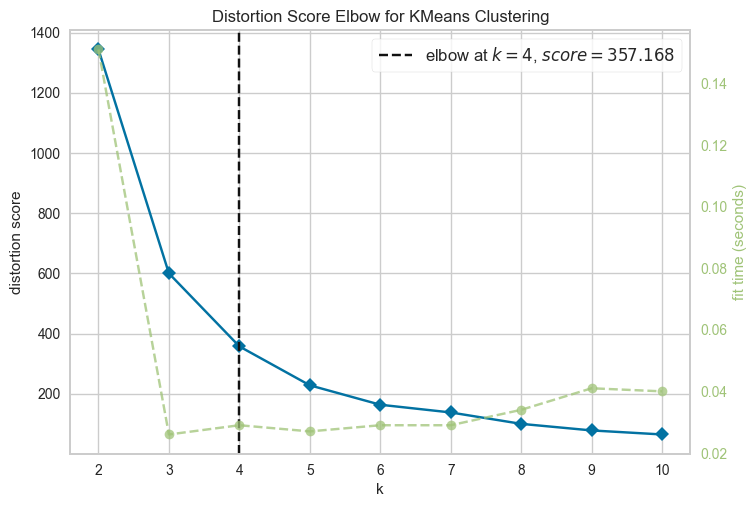

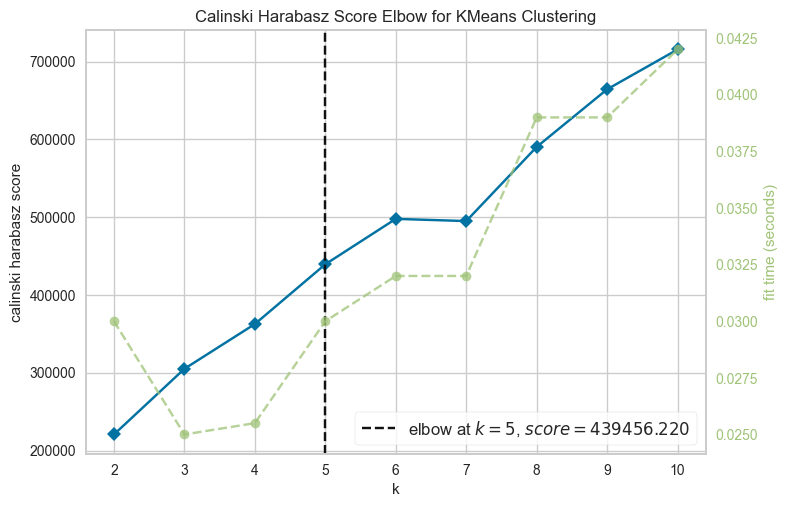

Temps d'exécution : 1.1505 secondes


['kmeans_model.joblib']

In [ ]:
# Démarrage du chronomètre
debut = time.time()

for i in ["distortion", "calinski_harabasz"]: # avec le "silhouette" la durée passe à 7m42.1s
    # Instanciation du modèle de clustering et du visualiseur
    model = cluster.KMeans(
        init="k-means++",
        n_init="auto",
        algorithm="lloyd",
        max_iter=300,
        tol=1e-4,
        random_state=77
    )
    visualizer = KElbowVisualizer(model, k=(2, 11), metric=i)

    visualizer.fit(rfm_scaled)
    visualizer.poof();

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution_km = fin - debut
print(f"Temps d'exécution : {temps_execution_km:.4f} secondes")

# Export du modèle dans un fichier
joblib.dump(model, "kmeans_model.joblib")

___
D'après les graphiques, le nombre optimal de clusters ce situe entre
- 4 pour le score de distortion
- 5 pour calinski_harabasz
- 2 avec le silhouette score
___

In [20]:
# Selection du nombre de clusters
kmean_cluster_nb = 5

J'ai testé avec 4 clusters les scores sont légèrement plus bas

Temps d'exécution : 0.0260 secondes (hors visualisation)


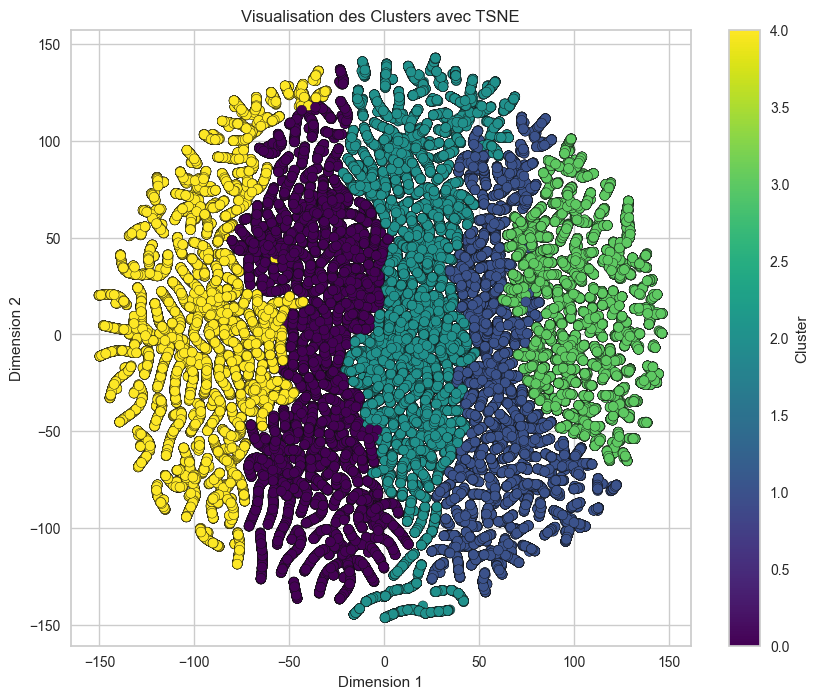

In [21]:
# Mesure du temps d'exécution
debut = time.time()

# Initialisation et entraînement de KMeans
clust_kmeans = KMeans(
    n_clusters=kmean_cluster_nb,
    init="k-means++",
    n_init="auto",
    algorithm="lloyd",
    max_iter=300,
    tol=1e-4,
    random_state=77
)
clust_kmeans.fit(rfm_scaled)

# Extraction des étiquettes de clusters
labels_kmeans = clust_kmeans.labels_

# Calcul du temps d'exécution
fin = time.time()
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution:.4f} secondes (hors visualisation)")

# Réduction de dimension avec TSNE pour visualisation
tsne = TSNE(n_components=2, random_state=77)
reduced_data_tsne = tsne.fit_transform(rfm_scaled)

# Visualisation des clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=labels_kmeans, cmap="viridis", marker="o", edgecolor="k", s=50)
plt.title("Visualisation des Clusters avec TSNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

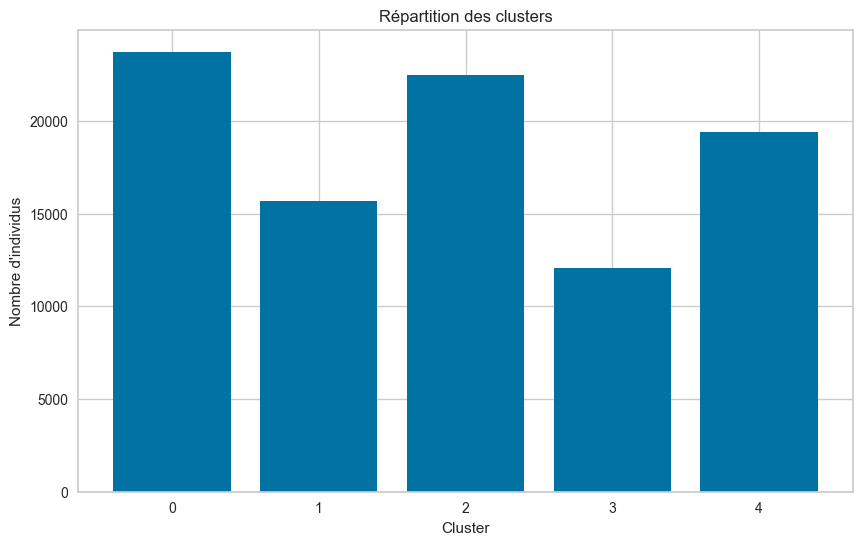

In [22]:
# Visualisation du nombre d'individus dans chaque cluster
unique, counts = np.unique(labels_kmeans, return_counts=True)

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(unique, counts)
plt.title("Répartition des clusters")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'individus")
plt.xticks(unique)
plt.show()


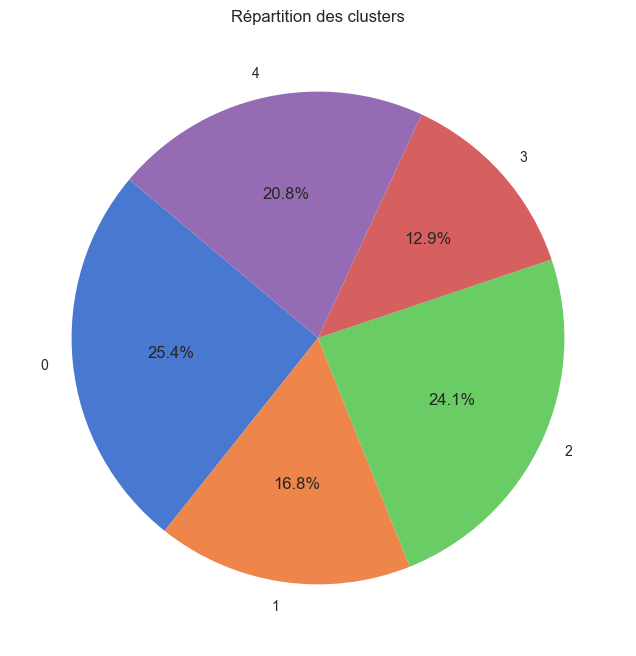

In [23]:
# Création du diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("muted", 10))
plt.title("Répartition des clusters")
plt.show()

In [24]:
# Aperçu des differents score
kmeans_silhouette = silhouette_score(rfm_scaled, labels_kmeans)
print(f"Score de silhouette : {kmeans_silhouette:0.3f}")
kmeans_calinski = calinski_harabasz_score(rfm_scaled, labels_kmeans)
print(f"Score de Calinski_Harabasz : {kmeans_calinski:0.3f}")
kmeans_bouldin = davies_bouldin_score(rfm_scaled, labels_kmeans)
print(f"Score de Davies_Bouldin : {kmeans_bouldin:0.3f}")
# Uniquement pour KMeans
print(f"Score de distortion : {clust_kmeans.inertia_:0.3f}")

Score de silhouette : 0.559
Score de Calinski_Harabasz : 439003.160
Score de Davies_Bouldin : 0.512
Score de distortion : 228.127


___
* Un score de 0.559 montre une séparation modérée entre les clusters. Cela signifie que les clusters sont relativement bien séparés, mais il y a des chevauchement des points qui sont proches de la frontière entre les clusters
___
* Un score de 439003.160 est élevé, ce qui suggère que les clusters sont bien séparés les uns des autres par rapport à la variance interne de chaque cluster.
___
* Un score de 0.512 est relativement bas, ce qui suggère que les clusters sont bien séparés et compacts. Cela renforce la qualité de la séparation observée avec le Calinski_Harabasz Score.
___
* Un score de 228.127 est assez bas, ce qui montre que les clusters sont compacts. Cela indique que les points à l'intérieur de chaque cluster sont proches de leur centre, ce qui est un signe de cohésion au sein des clusters.
___

<u>**Conclusions**</u>:    

Ces scores indiquent que les clusters sont bien séparés (Scores de Calinski_Harabasz et Davies_Bouldin favorables) et relativement cohérents et compacts (Scores de Distortion et de Silhouette modérés).

In [25]:
"""# Visualisation du score de silhouette
VisuSilhouette = True

if VisuSilhouette == True:
    visualizer = SilhouetteVisualizer(clust_kmeans)

    visualizer.fit(rfm_scaled)
    visualizer.poof();"""

'# Visualisation du score de silhouette\nVisuSilhouette = True\n\nif VisuSilhouette == True:\n    visualizer = SilhouetteVisualizer(clust_kmeans)\n\n    visualizer.fit(rfm_scaled)\n    visualizer.poof();'

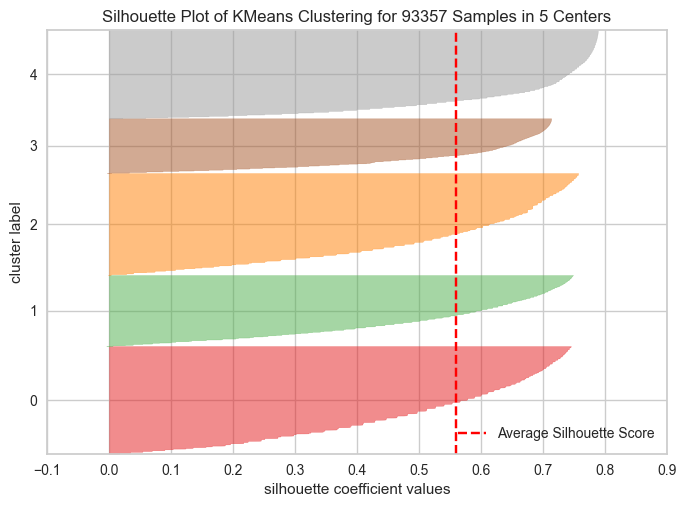

In [ ]:
# Convertion en tableau Numpy
clust_kmeans.fit(rfm_scaled.values)

# Visualisation du score de silhouette
VisuSilhouette = True

if VisuSilhouette == True:
    visualizer = SilhouetteVisualizer(clust_kmeans)

    visualizer.fit(rfm_scaled.values)
    visualizer.poof();

In [27]:
"""# Visualisation des distances interclusters
visualizer = InterclusterDistance(clust_kmeans)

visualizer.fit(rfm_scaled)
visualizer.show();"""

'# Visualisation des distances interclusters\nvisualizer = InterclusterDistance(clust_kmeans)\n\nvisualizer.fit(rfm_scaled)\nvisualizer.show();'

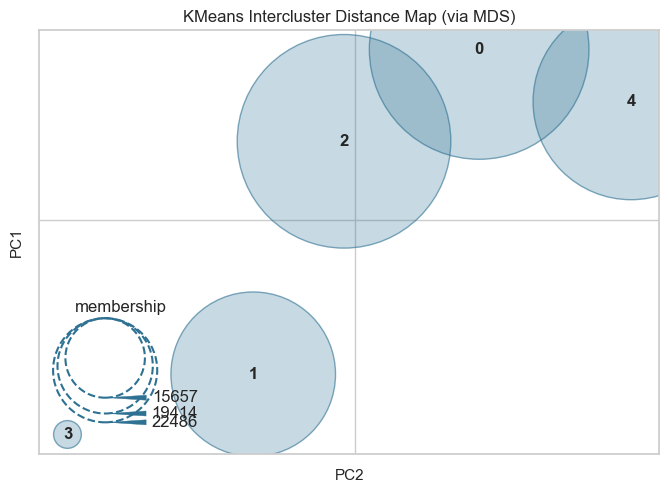

In [28]:
# Visualisation des distances interclusters
visualizer = InterclusterDistance(clust_kmeans)

visualizer.fit(rfm_scaled.values)
visualizer.show();

Cette visualisation montre une répartition majoritairement distincte entre les clusters, avec certains chevauchements. Cela fournit des indications sur la qualité de la séparation obtenue avec KMeans

In [29]:
model_rfm_kmeans = clust_kmeans
model_rfm_kmeans.fit(rfm_scaled)

KMeans(n_clusters=5, random_state=77)

In [ ]:
# Etiquettes de cluster
rfm_lab_5 = model_rfm_kmeans.predict(rfm_scaled)

In [ ]:
# Ajout des étiquettes pour la visualisation
rfm_kmeans_scaled_5 = rfm_scaled.copy()
rfm_kmeans_scaled_5["cluster"] = rfm_lab_5

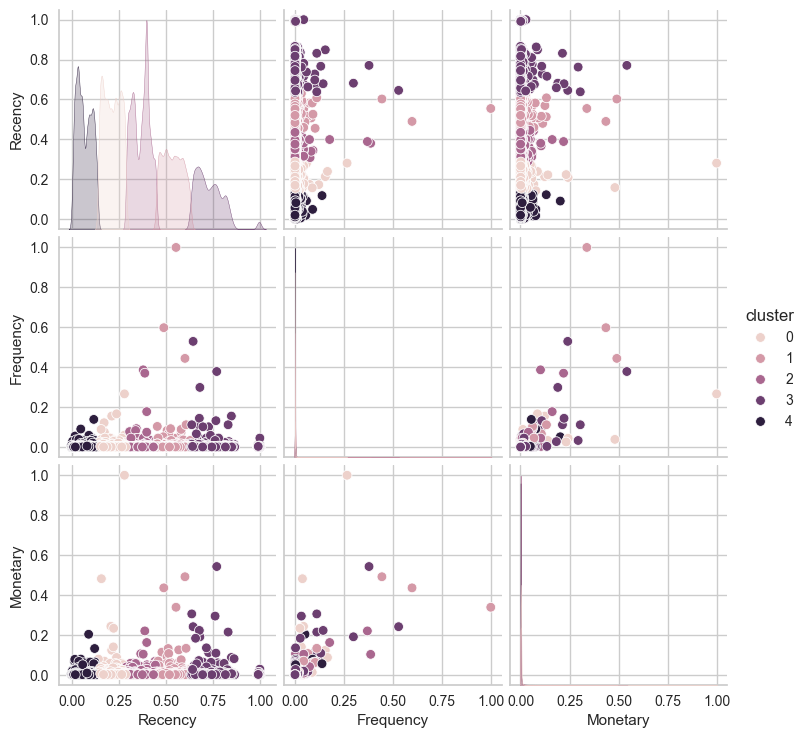

In [ ]:
# Visualisation des variables RFM
sns.pairplot(rfm_kmeans_scaled_5, hue="cluster")

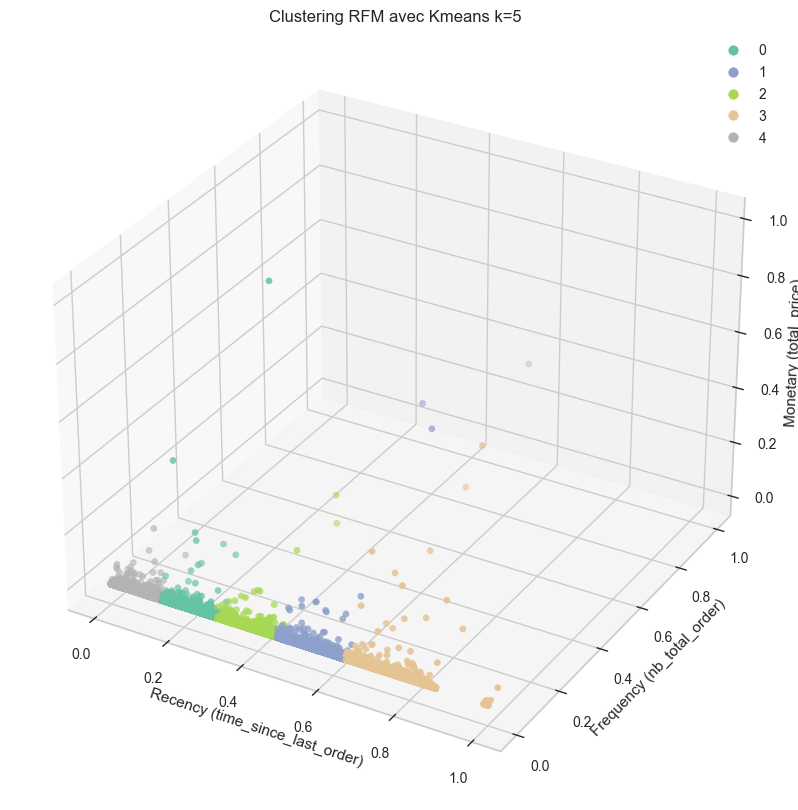

In [ ]:
# Représentation 3D du clustering RFM KMeans
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(rfm_kmeans_scaled_5.iloc[:, 0],
                    rfm_kmeans_scaled_5.iloc[:, 1],
                    rfm_kmeans_scaled_5.iloc[:, 2],
                    c=rfm_lab_5, cmap=plt.cm.Set2)

ax.legend(*scatter.legend_elements())
ax.set_xlabel("Recency (time_since_last_order)")
ax.set_ylabel("Frequency (nb_total_order)")
ax.set_zlabel("Monetary (total_price)")
ax.set_title("Clustering RFM avec Kmeans k=5")

plt.show()

In [ ]:
# Ajout des étiquettes pour la visualisation
rfm_kmeans_5 = data_rfm.copy()
rfm_kmeans_5["cluster"] = rfm_lab_5

In [35]:
radar_cluster(rfm_kmeans_5, "cluster", strat="mean")

<u>**Conclusion des KMeans :**</u>   

<u>Cluster 0</u> (clients dont la dernière commande remonte à un certain temps) :    
- Recency : Faible.
- Frequency : Très faible.
- Monetary : Très faible.
- Interprétation : Les clients de ce cluster semblent être peu engagés. Ils n'ont pas acheté récemment, ne dépensent pas beaucoup et réalisent peu d’achats.

<u>Cluster 1</u> (clients moyennement récents) :    

- Recency : Élevée.
- Frequency : Élevée.
- Monetary : Moyenne.
- Interprétation : Ce cluster représente des clients récents et modérément actifs. Ils montrent un certain potentiel de fidélisation.

<u>Cluster 2</u> (clients dont la dernière commande est ancienne) :

- Recency : Faible.
- Frequency : Très faible.
- Monetary : Très faible.
- Interprétation : Ce cluster regroupe des clients inactifs ou presque perdus, ils n’interagissent plus avec l’entreprise, et leur contribution est minimale.

<u>Cluster 3</u> (clients récents) :

- Recency : Très élevée.
- Frequency : Très élevée.
- Monetary : Très élevée.
- Interprétation : Ce cluster regroupe des clients très actifs et précieux. Ils sont non seulement engagés mais également parmi les contributeurs financiers les plus importants.

<u>Cluster 4</u> (clients dont la dernière commande date de très longtemps) :

- Recency : Très faible.
- Frequency : Très faible.
- Monetary : Très faible.
- Interprétation : Ce cluster regroupe des clients complètement inactifs ou perdus. Ils n'ont quasiment aucune interaction récente avec l'entreprise, et leur impact financier est inexistant.


Grace à ces observation cela nous permet de mieux comprendre la segmentation des clients en fonction de leur comportement d'achat.    
Cela peut permettre de guider des stratégie ciblées, comme la réactivation des clients inactifs ou le renforcement de la fidélité des clients qui sont eux très actifs

### DBSCAN

In [36]:
"""# Recherche des meilleurs paramètres eps
for e in [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1]:
    db_rfm_es = DBSCAN(eps=e, min_samples=5, n_jobs=-1)
    db_rfm_es.fit(rfm_scaled)
    db_lab_es = db_rfm_es.labels_

    print("Paramètres du modèle : epsilon : {}, min_samples : 5".format(e))
    print("Nombre de clusters avec le modèle DBSCAN : ",
        len(set(db_lab_es)) - (1 if -1 in db_lab_es else 0))
    print("Nombre de points considérés comme du bruit: ",
        list(db_lab_es).count(-1))
    print("Silhouette Score : ", silhouette_score(rfm_scaled, db_lab_es))
    print("Calinski_Harabasz Score : ", calinski_harabasz_score(rfm_scaled,
                                                                db_lab_es))
    print("Davies_Bouldin Score : ", davies_bouldin_score(rfm_scaled,
                                                        db_lab_es))"""

'# Recherche des meilleurs paramètres eps\nfor e in [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1]:\n    db_rfm_es = DBSCAN(eps=e, min_samples=5, n_jobs=-1)\n    db_rfm_es.fit(rfm_scaled)\n    db_lab_es = db_rfm_es.labels_\n\n    print("Paramètres du modèle : epsilon : {}, min_samples : 5".format(e))\n    print("Nombre de clusters avec le modèle DBSCAN : ",\n        len(set(db_lab_es)) - (1 if -1 in db_lab_es else 0))\n    print("Nombre de points considérés comme du bruit: ",\n        list(db_lab_es).count(-1))\n    print("Silhouette Score : ", silhouette_score(rfm_scaled, db_lab_es))\n    print("Calinski_Harabasz Score : ", calinski_harabasz_score(rfm_scaled,\n                                                                db_lab_es))\n    print("Davies_Bouldin Score : ", davies_bouldin_score(rfm_scaled,\n                                                        db_lab_es))'

In [37]:
# Démarrage du chronomètre
debut = time.time()

clust_DBSCAN = cluster.DBSCAN(eps=0.01, min_samples=5)
clust_DBSCAN.fit(rfm_scaled)
print("Labels :", np.unique(clust_DBSCAN.labels_), "(-1 représente le bruit).")

labels_dbscan = clust_DBSCAN.labels_

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution_db = fin - debut
print(f"Temps d'exécution : {temps_execution_db:.4f} secondes")

Labels : [-1  0  1  2  3] (-1 représente le bruit).
Temps d'exécution : 3.8676 secondes


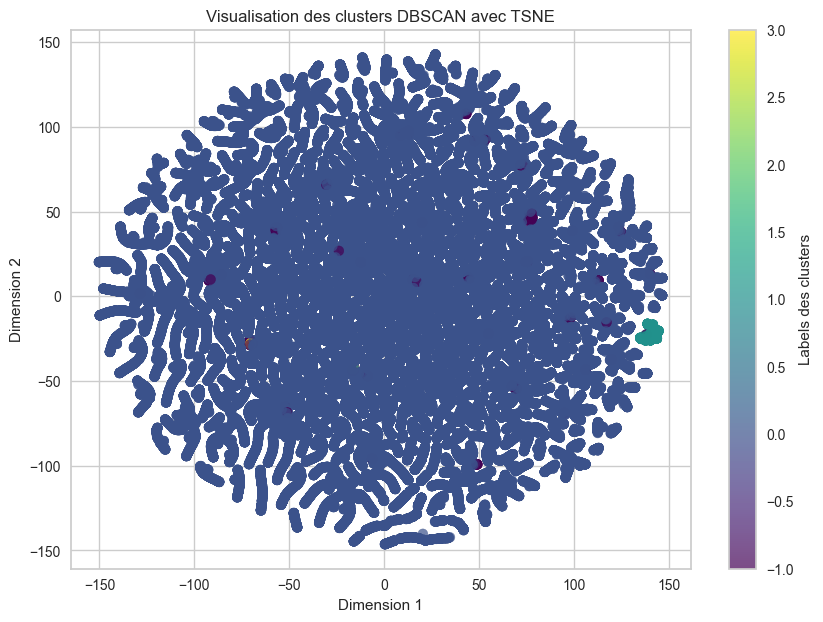

In [ ]:
# TSNE pour réduire les dimensions en 2D
tsne = TSNE(n_components=2, random_state=0)
rfm_tsne = tsne.fit_transform(rfm_scaled)

# Visualisation des clusters TSNE
plt.figure(figsize=(10, 7))
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=labels_dbscan, cmap="viridis", s=50, alpha=0.7)
plt.colorbar(label="Labels des clusters")
plt.title("Visualisation des clusters DBSCAN avec TSNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


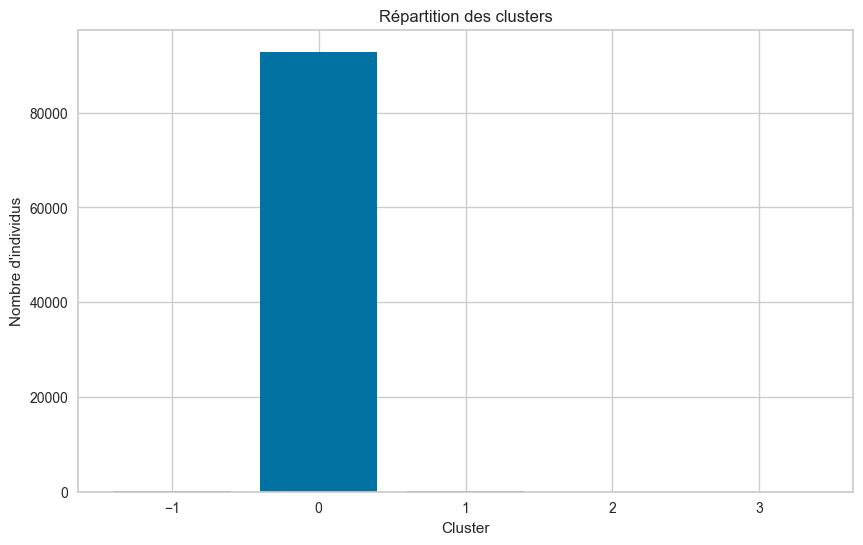

In [39]:
# Visualisation du nombre d'individus dans chaque cluster
unique, counts = np.unique(labels_dbscan, return_counts=True)

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(unique, counts)
plt.title("Répartition des clusters")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'individus")
plt.xticks(unique)
plt.show()

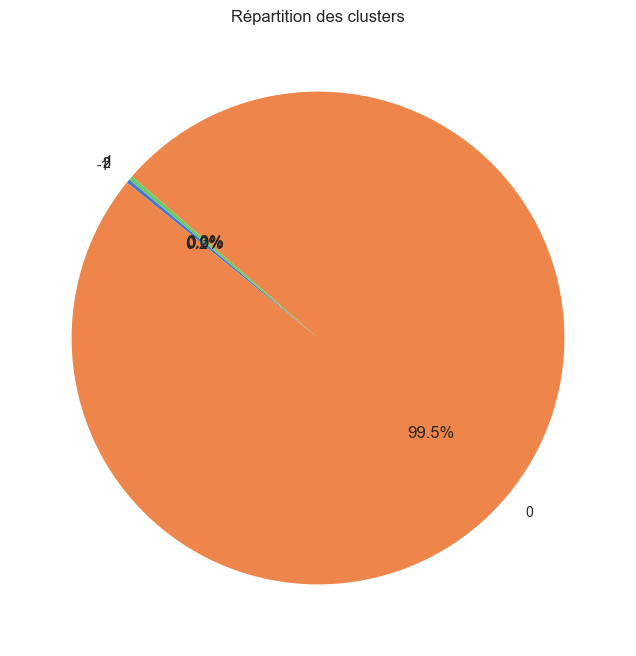

In [40]:
# Création du diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("muted", 10))
plt.title("Répartition des clusters")
plt.show()

In [ ]:
# Si (if) plus d'un cluster trouvé
if len(np.unique(labels_dbscan)) > 1:
    dbscan_silhouette = silhouette_score(rfm_scaled, labels_dbscan)
    print(f"Score de silhouette : {dbscan_silhouette:0.3f}")
    dbscan_bouldin = davies_bouldin_score(rfm_scaled, labels_dbscan)
    print(f"Score de Davies_Bouldin : {dbscan_bouldin:0.3f}")
    dbscan_calinski = calinski_harabasz_score(rfm_scaled, labels_dbscan)
    print(f"Score de Calinski_Harabasz : {dbscan_calinski:0.3f}")

# En cas d'impossibilité de calculer les scores
else:
    print("Pas suffisament de cluster pour calculer les scores.")

Score de silhouette : -0.496
Score de Davies_Bouldin : 2.297
Score de Calinski_Harabasz : 587.799


___
* Avec un score négatif, on peut conclure que les clusters formés par DBSCAN ne sont pas bien séparés ou que les données contiennent des points bruités mal assignés.
___
* Avec un score de 2.297, on peut conclure que les clusters manquent de séparation ou que leur forme/compacité n’est pas optimale.
___
* Un score de 587.799 est relativement bon, mais en combinaison avec les autres métriques (silhouette et Davies-Bouldin), il semble indiquer que les clusters ne sont pas optimaux.
___

In [42]:
db_rfm = DBSCAN(eps=0.01, min_samples=5, n_jobs=-1)

db_rfm.fit(rfm_scaled)

DBSCAN(eps=0.01, n_jobs=-1)

In [43]:
db_lab = db_rfm.labels_

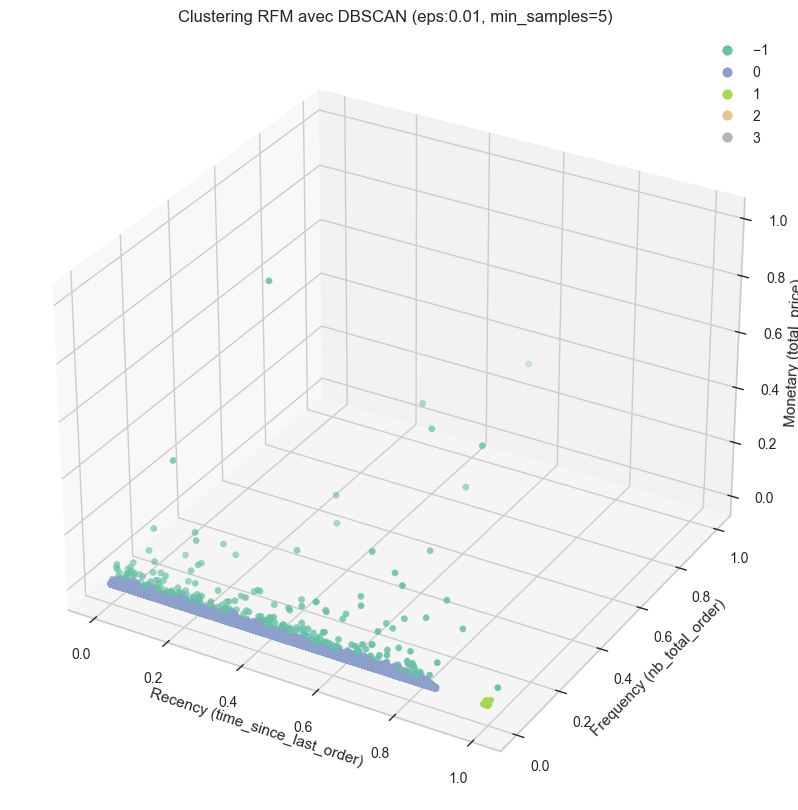

In [ ]:
# Représentation 3D du clustering RFM DBSCAN
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(rfm_scaled.iloc[:, 0],
                    rfm_scaled.iloc[:, 1],
                    rfm_scaled.iloc[:, 2],
                    c=db_lab, cmap=plt.cm.Set2)

ax.legend(*scatter.legend_elements())
ax.set_xlabel("Recency (time_since_last_order)")
ax.set_ylabel("Frequency (nb_total_order)")
ax.set_zlabel("Monetary (total_price)")
ax.set_title("Clustering RFM avec DBSCAN (eps:0.01, min_samples=5)")

plt.show()

In [ ]:
# Copie des données
rfm_db_04 = data_rfm.copy()

# Ajout des étiquettes
rfm_db_04["cluster"] = db_lab

# Suppression des valeurs (identifié comme "bruit")
rfm_db_04 = rfm_db_04[rfm_db_04["cluster"] != -1]

In [46]:
radar_cluster(rfm_db_04, "cluster", strat="mean")

<u>**Conclusion DBScan**</u> :    

- Dans le contexte RFM, ce modèle n'a pas permis d'identifié des clusters aussi pertinament qu'avec le KMeans.
- La répartition des individus indique clairement une répartition très inégale
- Les scores obtenus indiquent que le modèle de clustering ne parvient pas à segmenter efficacement les données.

Les résultats n'étant pas concluant, l'analyse des clusters n'est pas nécessaire.

### Agglomerative clustering

In [47]:
"""# Démarrage du chronomètre
debut = time.time()

# Teste de différentes métriques afin de trouver le nombre optimal de clusters
for i in ["distortion", "calinski_harabasz"]:  # "silhouette" possible
    # Instanciation du modèle de clustering et du visualiseur
    model = cluster.AgglomerativeClustering(linkage="ward")
    visualizer = KElbowVisualizer(model, k=(2, 7), metric=i)

    # Fit du visualiseur
    visualizer.fit(rfm_scaled)
    visualizer.poof()

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution:.4f} secondes")"""

# Temps d'exécution : 3896.3849 secondes (64 minutes)

'# Démarrage du chronomètre\ndebut = time.time()\n\n# Teste de différentes métriques afin de trouver le nombre optimal de clusters\nfor i in ["distortion", "calinski_harabasz"]:  # "silhouette" possible\n    # Instanciation du modèle de clustering et du visualiseur\n    model = cluster.AgglomerativeClustering(linkage="ward")\n    visualizer = KElbowVisualizer(model, k=(2, 7), metric=i)\n\n    # Fit du visualiseur\n    visualizer.fit(rfm_scaled)\n    visualizer.poof()\n\n# Arrêt du chronomètre\nfin = time.time()\n\n# Calcul du temps d\'exécution\ntemps_execution = fin - debut\nprint(f"Temps d\'exécution : {temps_execution:.4f} secondes")'

In [48]:
# Selection du nombre de clusters
opti_clusters = 4

# Démarrage du chronomètre
debut = time.time()

# Instanciation et fit du modèle AgglomerativeClustering
clust_agglomerative = cluster.AgglomerativeClustering(
    n_clusters=opti_clusters,
    linkage="ward"
)
labels_agglomerative = clust_agglomerative.fit_predict(rfm_scaled)

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution_aggc = fin - debut
print(f"Temps d'exécution : {temps_execution_aggc:.4f} secondes")
print("Labels :", np.unique(labels_agglomerative))

Temps d'exécution : 434.8105 secondes
Labels : [0 1 2 3]


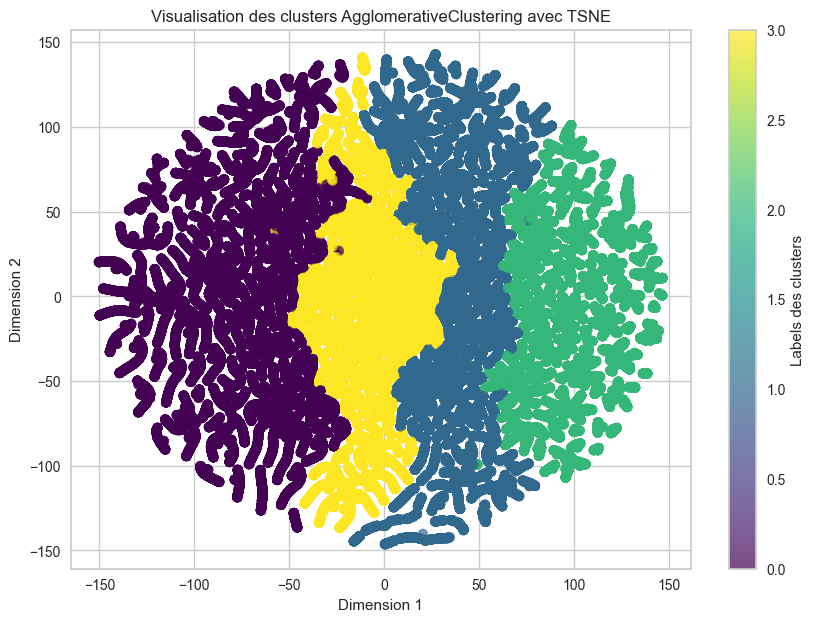

In [ ]:
# TSNE pour réduire les données à 2 dimensions
tsne = TSNE(n_components=2, random_state=77)
rfm_tsne = tsne.fit_transform(rfm_scaled)

# Visualisation des clusters TSNE
plt.figure(figsize=(10, 7))
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=labels_agglomerative, cmap="viridis", s=50, alpha=0.7)
plt.colorbar(label="Labels des clusters")
plt.title("Visualisation des clusters AgglomerativeClustering avec TSNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

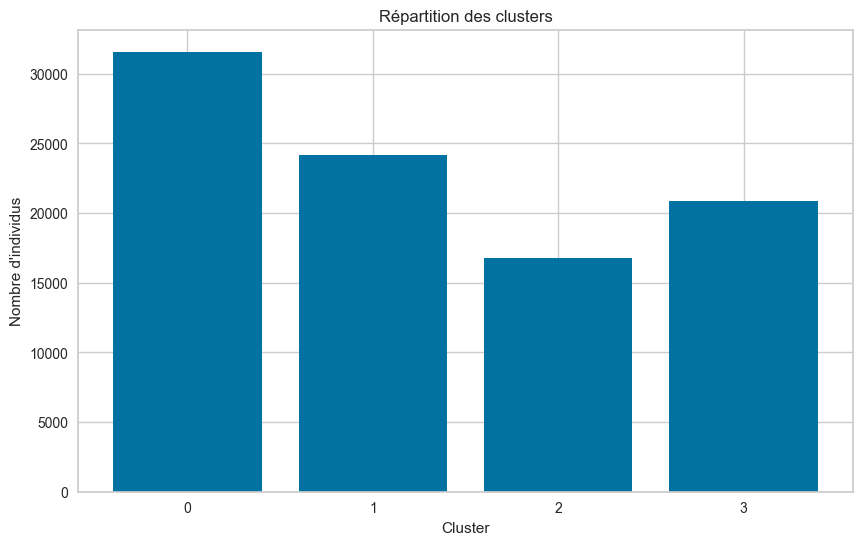

In [50]:
# Visualisation du nombre d'individus dans chaque cluster
unique, counts = np.unique(labels_agglomerative, return_counts=True)

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(unique, counts)
plt.title("Répartition des clusters")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'individus")
plt.xticks(unique)
plt.show()

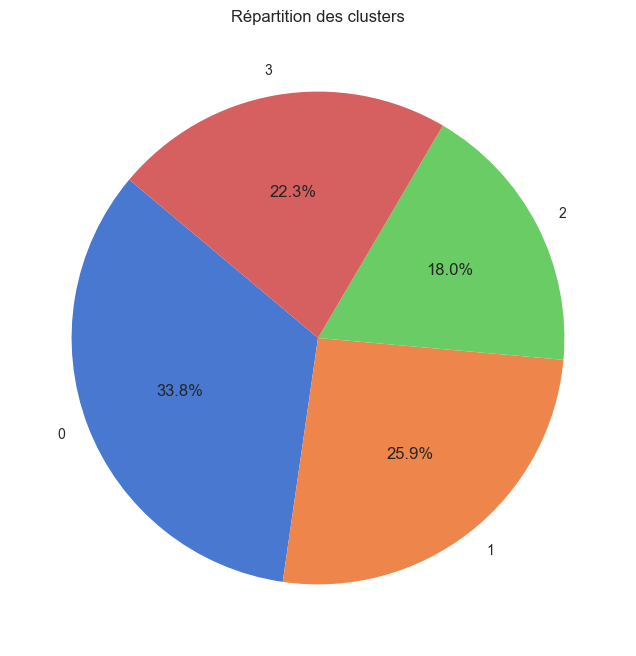

In [51]:
# Création du diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("muted", 10))
plt.title("Répartition des clusters")
plt.show()

In [52]:
# Aperçu des differents score
aggc_silhouette = silhouette_score(rfm_scaled, labels_agglomerative)
print(f"Score de silhouette : {kmeans_silhouette:0.3f}")
aggc_calinski = calinski_harabasz_score(rfm_scaled, labels_agglomerative)
print(f"Score de Calinski_Harabasz : {kmeans_calinski:0.3f}")
aggc_bouldin = davies_bouldin_score(rfm_scaled, labels_agglomerative)
print(f"Score de Davies_Bouldin : {kmeans_bouldin:0.3f}")

Score de silhouette : 0.559
Score de Calinski_Harabasz : 439003.160
Score de Davies_Bouldin : 0.512


___
* Avec un score de 0.559, l'Agglomerative Clustering semble avoir bien partitionné les données, avec des clusters globalement bien séparés.
___
* Avec un score de 439003.160, la séparation entre les clusters est optimale, et chaque cluster est cohérent en termes de composition interne.
___
* Un score de 0.512, l'agglomération a produit des clusters qui respectent une bonne compacité et séparation, confirmant une qualité élevée du clustering.
___

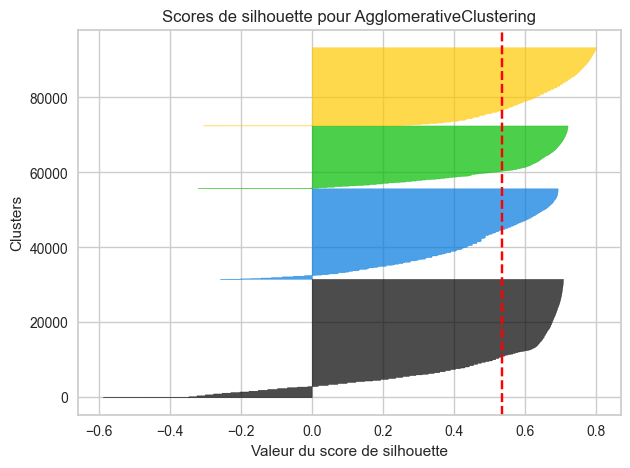

In [53]:
# Calcul des scores de silhouette
silhouette_avg = silhouette_score(rfm_scaled, labels_agglomerative)
silhouette_vals = silhouette_samples(rfm_scaled, labels_agglomerative)

# Affichage du score de silhouette
fig, ax = plt.subplots(figsize=(7, 5))
y_lower = 10
for i in range(opti_clusters):
    ith_cluster_silhouette_values = silhouette_vals[labels_agglomerative == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / opti_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_xlabel("Valeur du score de silhouette")
ax.set_ylabel("Clusters")
ax.set_title("Scores de silhouette pour AgglomerativeClustering")
plt.show()

In [54]:
model_rfm_aggc = clust_agglomerative
model_rfm_aggc.fit(rfm_scaled)

AgglomerativeClustering(n_clusters=4)

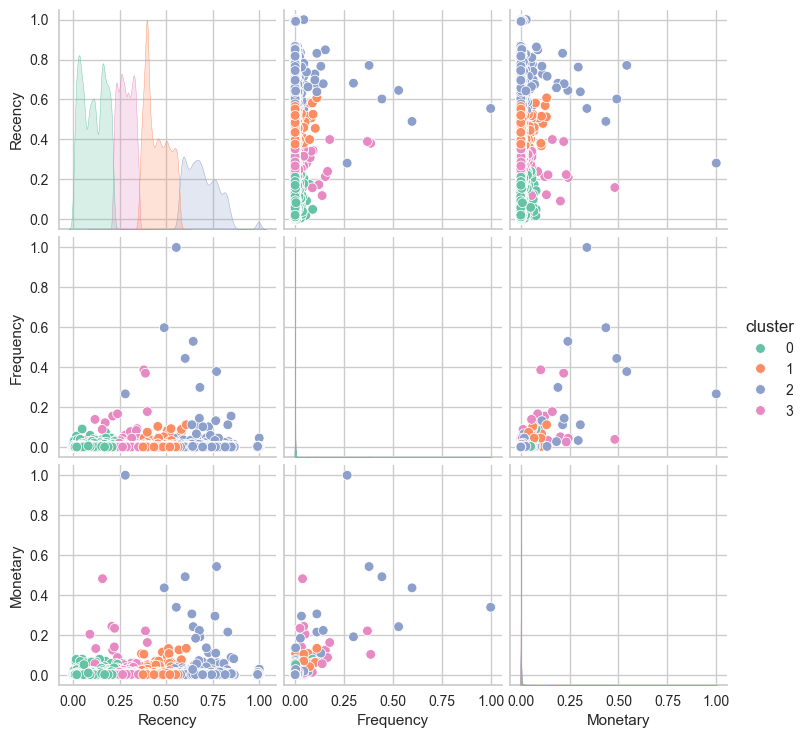

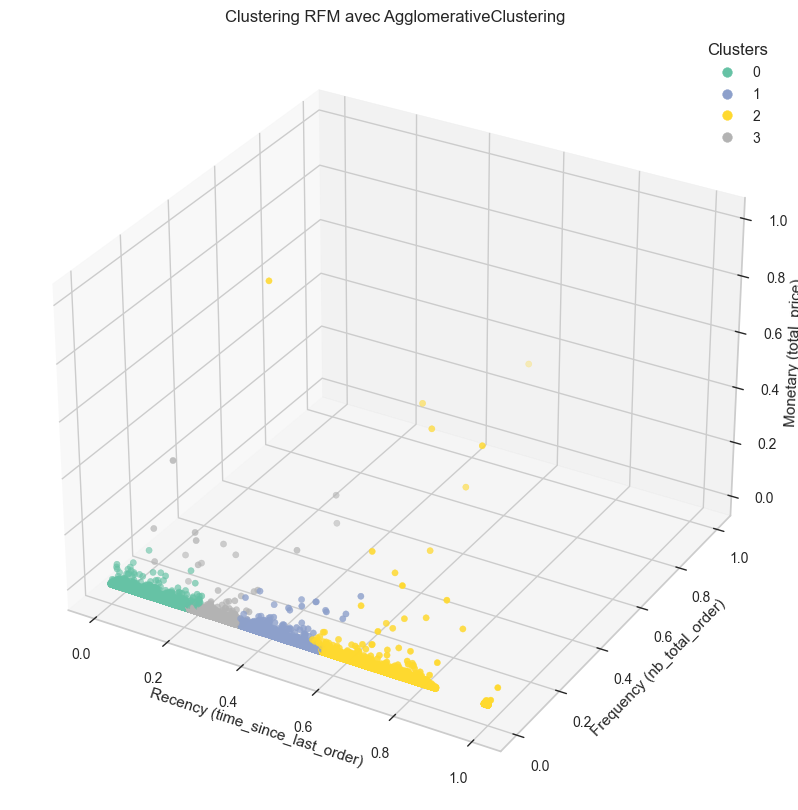

In [55]:
# Ajout des labels de cluster
rfm_aggc_scaled_4 = rfm_scaled.copy()
rfm_aggc_scaled_4["cluster"] = labels_agglomerative

# Visualisation
sns.pairplot(rfm_aggc_scaled_4, hue="cluster", palette="Set2")
plt.show()

# Visualisation 3D des clusters
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(rfm_aggc_scaled_4.iloc[:, 0],
                    rfm_aggc_scaled_4.iloc[:, 1],
                    rfm_aggc_scaled_4.iloc[:, 2],
                    c=labels_agglomerative, cmap=plt.cm.Set2)

# Légende
ax.legend(*scatter.legend_elements(), title="Clusters")
ax.set_xlabel("Recency (time_since_last_order)")
ax.set_ylabel("Frequency (nb_total_order)")
ax.set_zlabel("Monetary (total_price)")
ax.set_title("Clustering RFM avec AgglomerativeClustering")

plt.show()

In [56]:
radar_cluster(rfm_aggc_scaled_4, "cluster", strat="mean")

<u>**Conclusion Agglomérative Clustering**</u> :    

<u>Cluster 0</u> :    
- Recency : Faible.
- Frequency : Faible.
- Monetary : Très faible.
- Interprétation : Les clients de ce cluster semblent être inactifs, avec peu d'engagement en termes de récence, fréquence et dépenses monétaires.

<u>Cluster 1</u> :    

- Récency : Élevée.
- Fréquency : Très faible.
- Monetary : Faible.
- Interprétation : Les clients de ce cluster ont passé une commande relativement récente, mais ils achètent très peu souvent et dépensent peu.

<u>Cluster 2</u> :

- Recency : Très élevé.
- Frequency : Très élevé.
- Monetary : Très élevé.
- Interprétation : Clients inactifs depuis longtemps, potentiellement perdus.

<u>Cluster 3</u> : Ce cluster représente les meilleurs clients, il sont récents, fréquents dans leurs achats, et apportent une valeur monétaire élevée.

- Recency : Moyenne.
- Frequency : Faible.
- Monetary : Faible.
- Interprétation : Les clients de ce cluster ont une activité modérée en termes de récence, mais leur fréquence d’achat et leur contribution monétaire sont faibles.


### Classification Ascendante Hierarchique (CAH)

In [57]:
ARI = []
for s in [5000, 10000, 30000, 50000, 70000, 90000]:
    X = data_rfm.sample(n=s, random_state=77).copy()
    X_scaled = pd.DataFrame(preprocessor.fit_transform(X),
                            index=X.index,
                            columns=X.columns)

    kmeans_sample = KMeans(5, random_state=77)
    kmeans_sample.fit(X_scaled)
    kmeans_sample_lab = kmeans_sample.predict(X_scaled)

    kmeans_lab = model_rfm_kmeans.predict(X_scaled)

    ARI_score = adjusted_rand_score(kmeans_lab, kmeans_sample_lab)
    ARI.append([s, ARI_score])

print("Scores ARI pour chaque sample :")
display(pd.DataFrame(ARI, columns=["Échantillons", "ARI"]))

Scores ARI pour chaque sample :


Échantillons       ARI
0          5000  0.900805
1         10000  0.878032
2         30000  0.895262
3         50000  0.874843
4         70000  0.916356
5         90000  0.916649

Les scores ARI pour chaque échantillons permettent de voir si la structure de clustering reste stable en fonction de la taille de l'échantillon.    
Des scores proches de 1 indiqueraient que les clusters sont robustes et cohérents entre les sous-échantillons et l’ensemble de données complet.

In [ ]:
# Sélection du nombre d'échantillons
X_reduced = data_rfm.sample(n=30000, random_state=77).copy()

Je séléctionne 30000 échantillons, ce qui me permet de réduire le dataset mais en conservant un ARI très élevé (0.89).

In [ ]:
# Mise a l'échelle des données
X_red_scaled = pd.DataFrame(preprocessor.fit_transform(X_reduced),
                            index=X_reduced.index,
                            columns=X_reduced.columns)

# Calcul de la matrice de regroupement
Z = linkage(X_red_scaled, method="ward")

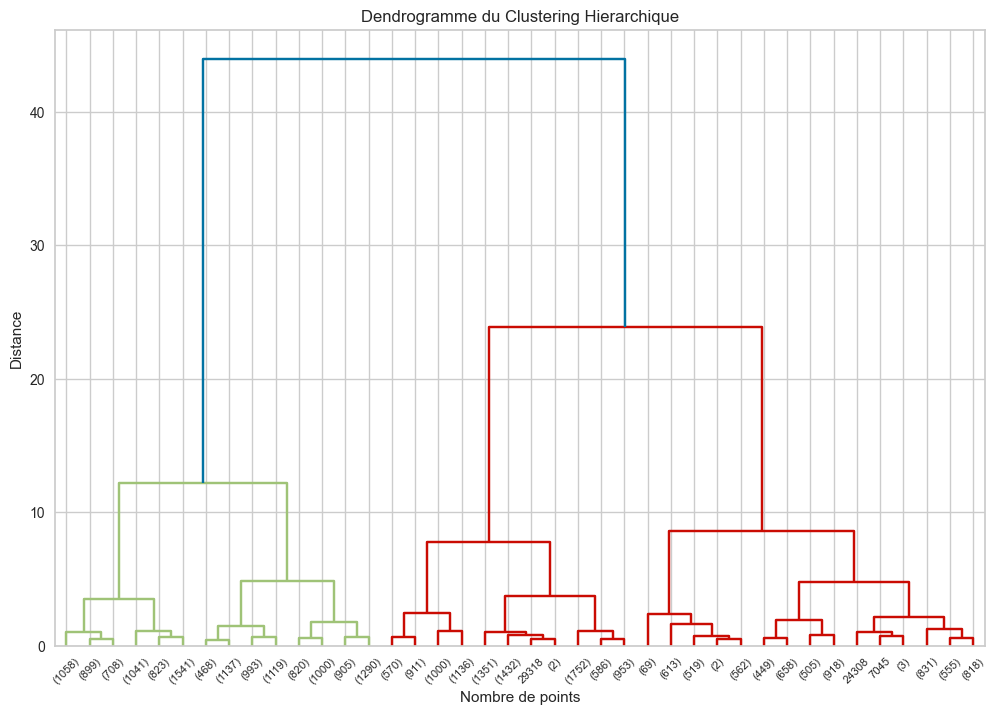

In [ ]:
# Visualisation du dendrogram
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z, p=40, truncate_mode="lastp", ax=ax)

plt.title("Dendrogramme du Clustering Hierarchique")
plt.xlabel("Nombre de points")
plt.ylabel("Distance")
plt.show()

In [ ]:
# Analyses des regroupements pour les differents clusters
k_sil_lab = []
mod_cah = []

for k in range(2, 11):
    cah = AgglomerativeClustering(n_clusters=k)
    cah.fit(X_red_scaled)

    cah_lab = cah.labels_
    score = silhouette_score(X_red_scaled, cah_lab)

    k_sil_lab.append([k, score, cah_lab])
    mod_cah.append([k, cah])
    print("Boucle k = {} terminée".format(k))

display(k_sil_lab)

Boucle k = 2 terminée
Boucle k = 3 terminée
Boucle k = 4 terminée
Boucle k = 5 terminée
Boucle k = 6 terminée
Boucle k = 7 terminée
Boucle k = 8 terminée
Boucle k = 9 terminée
Boucle k = 10 terminée


[[2, np.float64(0.5622708108885286), array([1, 0, 0, ..., 0, 0, 1])],
 [3, np.float64(0.5671414721547219), array([0, 1, 2, ..., 1, 2, 0])],
 [4, np.float64(0.55366096371258), array([3, 0, 2, ..., 0, 2, 1])],
 [5, np.float64(0.5314343680135415), array([3, 4, 0, ..., 4, 0, 1])],
 [6, np.float64(0.524453225362402), array([3, 4, 5, ..., 4, 1, 0])],
 [7, np.float64(0.5027361638324784), array([3, 4, 2, ..., 4, 1, 5])],
 [8, np.float64(0.5131544056117625), array([1, 4, 2, ..., 4, 0, 5])],
 [9, np.float64(0.5298138752942293), array([0, 1, 2, ..., 1, 4, 5])],
 [10, np.float64(0.5356489738156363), array([5, 1, 0, ..., 1, 4, 2])]]

In [62]:
print("Paramètres du modèle CAH: k=2.")
print("Silhouette Score : ", silhouette_score(X_red_scaled, k_sil_lab[0][2]))
print("Davies Bouldin Score : ", davies_bouldin_score(X_red_scaled,
                                                    k_sil_lab[0][2]))
print("Calinski Harabasz Score : ", calinski_harabasz_score(X_red_scaled,
                                                            k_sil_lab[0][2]))

Paramètres du modèle CAH: k=2.
Silhouette Score :  0.5622708108885286
Davies Bouldin Score :  0.5701294873715259
Calinski Harabasz Score :  59240.17258579552


In [63]:
print("Paramètres du modèle CAH: k=3.")
print("Silhouette Score : ", silhouette_score(X_red_scaled, k_sil_lab[1][2]))
print("Davies Bouldin Score : ", davies_bouldin_score(X_red_scaled,
                                                    k_sil_lab[1][2]))
print("Calinski Harabasz Score : ", calinski_harabasz_score(X_red_scaled,
                                                            k_sil_lab[1][2]))

Paramètres du modèle CAH: k=3.
Silhouette Score :  0.5671414721547219
Davies Bouldin Score :  0.5078368599930886
Calinski Harabasz Score :  92615.00876061755


In [64]:
print("Paramètres du modèle CAH: k=4.")
print("Silhouette Score : ", silhouette_score(X_red_scaled, k_sil_lab[2][2]))
print("Davies Bouldin Score : ", davies_bouldin_score(X_red_scaled,
                                                    k_sil_lab[2][2]))
print("Calinski Harabasz Score : ", calinski_harabasz_score(X_red_scaled,
                                                            k_sil_lab[2][2]))

Paramètres du modèle CAH: k=4.
Silhouette Score :  0.55366096371258
Davies Bouldin Score :  0.49874709393142475
Calinski Harabasz Score :  103214.63367280111


In [65]:
print("Paramètres du modèle CAH: k=5.")
print("Silhouette Score : ", silhouette_score(X_red_scaled, k_sil_lab[3][2]))
print("Davies Bouldin Score : ", davies_bouldin_score(X_red_scaled,
                                                    k_sil_lab[3][2]))
print("Calinski Harabasz Score : ", calinski_harabasz_score(X_red_scaled,
                                                            k_sil_lab[3][2]))

Paramètres du modèle CAH: k=5.
Silhouette Score :  0.5314343680135415
Davies Bouldin Score :  0.5055855967729115
Calinski Harabasz Score :  112101.52032980704


In [66]:
print("Paramètres du modèle CAH: k=6.")
print("Silhouette Score : ", silhouette_score(X_red_scaled, k_sil_lab[4][2]))
print("Davies Bouldin Score : ", davies_bouldin_score(X_red_scaled,
                                                    k_sil_lab[4][2]))
print("Calinski Harabasz Score : ", calinski_harabasz_score(X_red_scaled,
                                                            k_sil_lab[4][2]))

Paramètres du modèle CAH: k=6.
Silhouette Score :  0.524453225362402
Davies Bouldin Score :  0.5261562389340679
Calinski Harabasz Score :  137460.74161185237


In [67]:
# Visualisation K2
X_red_cah_k2 = X_reduced.copy()
X_red_cah_k2["cluster"] = k_sil_lab[0][2]

radar_cluster(X_red_cah_k2, "cluster", strat="mean")

In [68]:
# Visualisation K3
X_red_cah_k3 = X_reduced.copy()
X_red_cah_k3["cluster"] = k_sil_lab[1][2]

radar_cluster(X_red_cah_k3, "cluster", strat="mean")

In [69]:
# Visualisation K4
X_red_cah_k4 = X_reduced.copy()
X_red_cah_k4["cluster"] = k_sil_lab[2][2]

radar_cluster(X_red_cah_k4, "cluster", strat="mean")

In [70]:
# Visualisation K5
X_red_cah_k5 = X_reduced.copy()
X_red_cah_k5["cluster"] = k_sil_lab[3][2]

radar_cluster(X_red_cah_k5, "cluster", strat="mean")

In [71]:
# Visualisation K6
X_red_cah_k6 = X_reduced.copy()
X_red_cah_k6["cluster"] = k_sil_lab[4][2]

radar_cluster(X_red_cah_k6, "cluster", strat="mean")

Bien que les scores soit dans une plage acceptable, les résultats ne sont pas concluant avec cette CAH de plus ils sont soumis à un échantillonage du dataset.

On peut néanmoins observé qu'un k3 ou k4 semble être le bon compromis ce que confirme également les indices de Davis_Bouldin et de Calinski_Harabasz.

### Spectral Clustering

In [72]:
"""# Démarrage du chronomètre
debut = time.time()

for i in ["distortion", "calinski_harabasz"]: # métriques pour évaluer le nombre de clusters optimal
    # Instanciation du modèle de clustering et du visualiseur
    model = cluster.SpectralClustering(
        affinity="nearest_neighbors",
        random_state=77,
        n_neighbors=10
    )
    visualizer = KElbowVisualizer(model, k=(2, 11), metric=i)

    visualizer.fit(rfm_scaled)
    visualizer.poof();

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution:.4f} secondes")"""

'# Démarrage du chronomètre\ndebut = time.time()\n\nfor i in ["distortion", "calinski_harabasz"]: # métriques pour évaluer le nombre de clusters optimal\n    # Instanciation du modèle de clustering et du visualiseur\n    model = cluster.SpectralClustering(\n        affinity="nearest_neighbors",\n        random_state=77,\n        n_neighbors=10\n    )\n    visualizer = KElbowVisualizer(model, k=(2, 11), metric=i)\n\n    visualizer.fit(rfm_scaled)\n    visualizer.poof();\n\n# Arrêt du chronomètre\nfin = time.time()\n\n# Calcul du temps d\'exécution\ntemps_execution = fin - debut\nprint(f"Temps d\'exécution : {temps_execution:.4f} secondes")'

La demande en mémoire vive étant trop importante je n'est pas continué avec ce modèle

## RFM + satisfaction

In [ ]:
# Création de la variable
rfm_sat = data_clients[["customer_unique_id", "time_since_last_order", "nb_total_order", "total_price", "mean_review_score"]].copy()

In [77]:
rfm_sat = rfm_sat.set_index("customer_unique_id")
rfm_sat.columns = ["Recency", "Frequency", "Monetary", "Score"]

In [78]:
rfm_sat.head()

Recency  Frequency  Monetary  Score
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2      111          1    129.90    5.0
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     18.90    4.0
0000f46a3911fa3c0805444483337064      536          1     69.00    3.0
0000f6ccb0745a6a4b88665a16c9f078      320          1     25.99    4.0
0004aac84e0df4da2b147fca70cf8255      287          1    180.00    5.0

In [ ]:
# Préparation des variables quantitative et qualitative
col_quanti = rfm_sat.select_dtypes(["int64", "float64"]).columns
col_quali = rfm_sat.select_dtypes(["category", "object", "bool"]).columns

# Encodage
minmax_scale = MinMaxScaler()
ohe = OneHotEncoder()

preprocessor = ColumnTransformer(transformers=[
    ("quanti", minmax_scale, col_quanti),
    ("quali", ohe, col_quali)
])

In [80]:
rfm_score_scaled = pd.DataFrame(preprocessor.fit_transform(rfm_sat),
                                index=rfm_sat.index,
                                columns=rfm_sat.columns)
rfm_score_scaled.head()

Recency  Frequency  Monetary  Score
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2  0.159942        0.0  0.001088   1.00
0000b849f77a49e4a4ce2b2a4ca5be3f  0.164265        0.0  0.000152   0.75
0000f46a3911fa3c0805444483337064  0.772334        0.0  0.000574   0.50
0000f6ccb0745a6a4b88665a16c9f078  0.461095        0.0  0.000212   0.75
0004aac84e0df4da2b147fca70cf8255  0.413545        0.0  0.001510   1.00

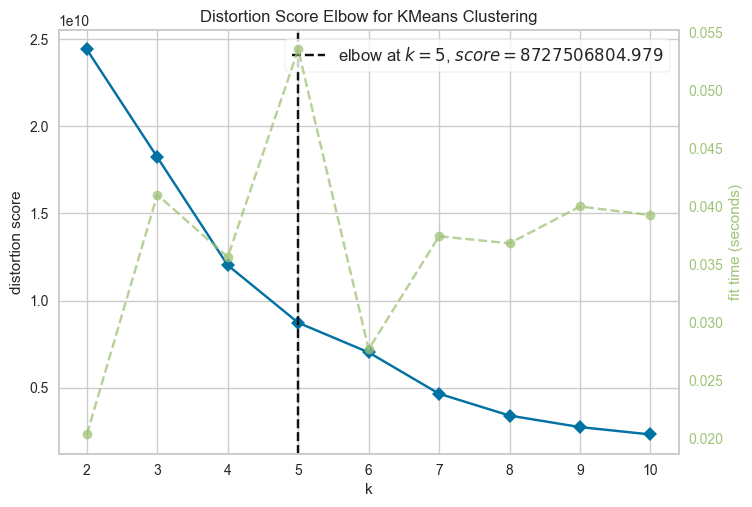

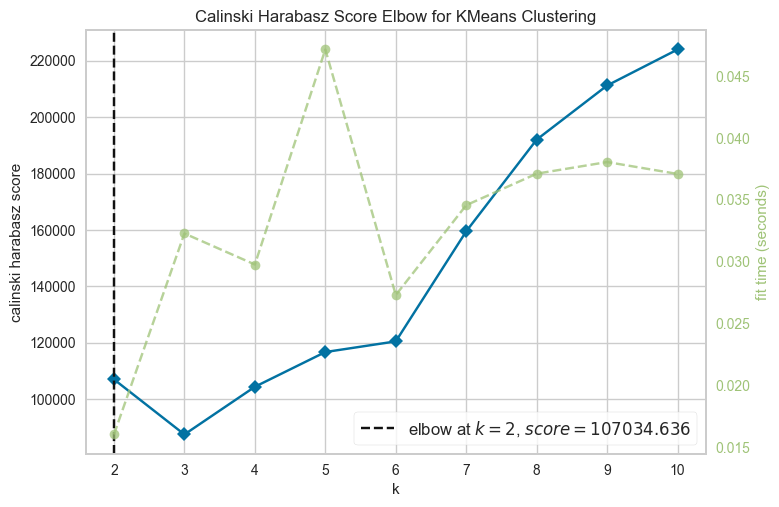

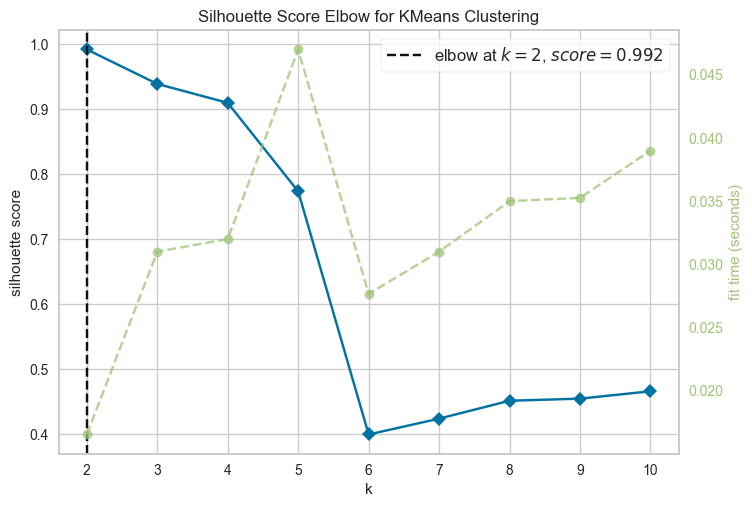

Temps d'exécution : 503.3135 secondes


In [ ]:
# Démarrage du chronomètre
debut = time.time()

for i in ["distortion", "calinski_harabasz"]: # avec le "silhouette" la durée passe à 8m23.3s
    # Instanciation du modèle de clustering et du visualiseur
    model = cluster.KMeans(
        init="k-means++",
        n_init="auto",
        algorithm="lloyd",
        max_iter=300,
        tol=1e-4,
        random_state=77
    )
    visualizer = KElbowVisualizer(model, k=(2, 11), metric=i)

    visualizer.fit(rfm_sat)
    visualizer.poof();

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution_km = fin - debut
print(f"Temps d'exécution : {temps_execution_km:.4f} secondes")

In [83]:
# Selection du nombre de clusters
kmean_nb_k_rfm_sat = 2

Temps d'exécution : 0.0190 secondes (hors visualisation)


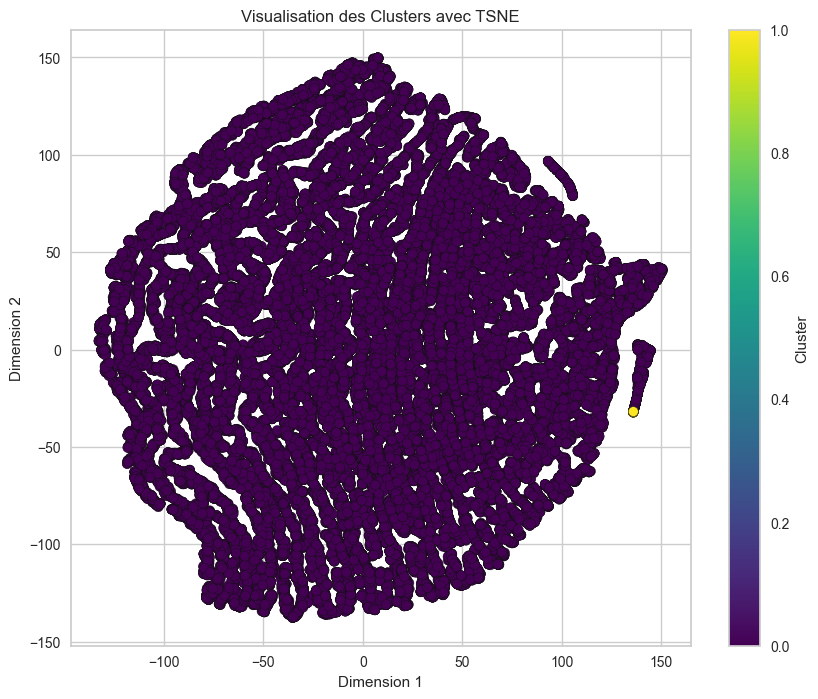

In [84]:
# Mesure du temps d'exécution
debut = time.time()

# Initialisation et entraînement de KMeans
k_kmeans_rfm_sat = KMeans(
    n_clusters=kmean_nb_k_rfm_sat,
    init="k-means++",
    n_init="auto",
    algorithm="lloyd",
    max_iter=300,
    tol=1e-4,
    random_state=77
)
k_kmeans_rfm_sat.fit(rfm_sat)

# Extraction des étiquettes de clusters
labels_kmeans_rfm_sat = k_kmeans_rfm_sat.labels_

# Calcul du temps d'exécution
fin = time.time()
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution:.4f} secondes (hors visualisation)")

# Réduction de dimension avec TSNE pour visualisation
tsne_2 = TSNE(n_components=2, random_state=77)
reduced_data_tsne_rfm_sat = tsne_2.fit_transform(rfm_sat)

# Visualisation des clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data_tsne_rfm_sat[:, 0], reduced_data_tsne_rfm_sat[:, 1], c=labels_kmeans_rfm_sat, cmap="viridis", marker="o", edgecolor="k", s=50)
plt.title("Visualisation des Clusters avec TSNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

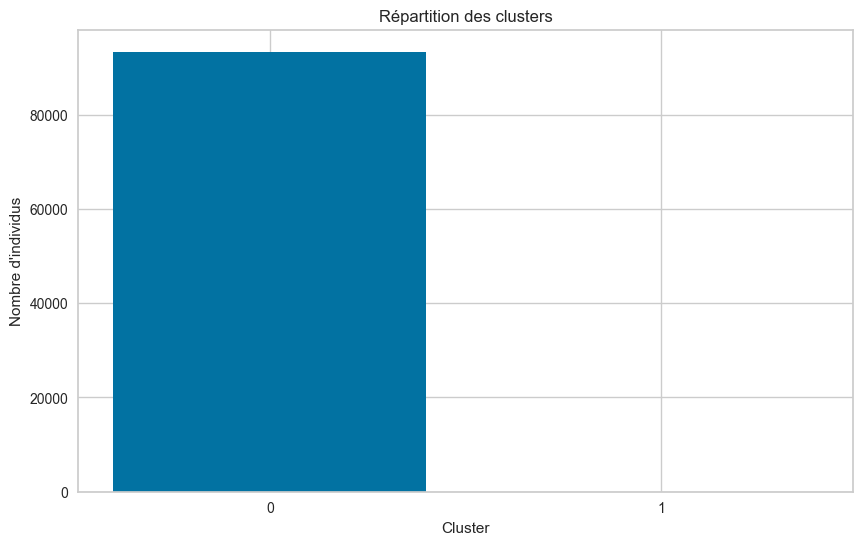

In [86]:
# Visualisation du nombre d'individus dans chaque cluster
unique2, counts2 = np.unique(labels_kmeans_rfm_sat, return_counts=True)

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(unique2, counts2)
plt.title("Répartition des clusters")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'individus")
plt.xticks(unique2)
plt.show()


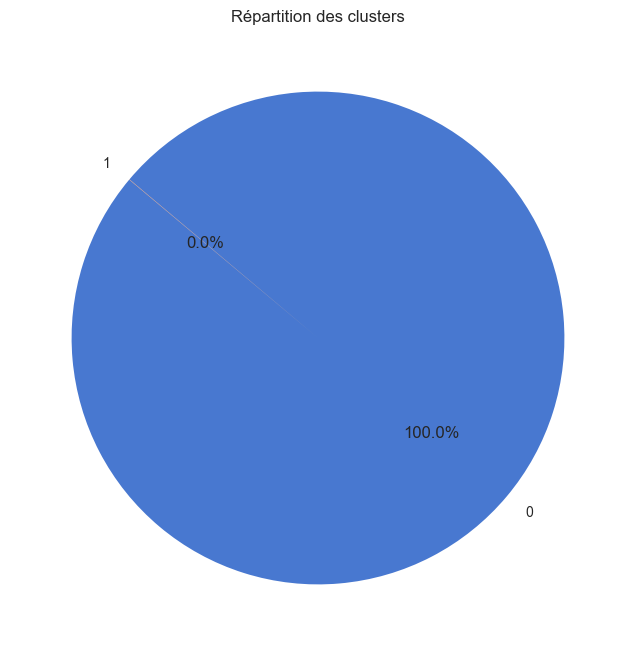

In [87]:
# Création du diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(counts2, labels=unique2, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("muted", 10))
plt.title("Répartition des clusters")
plt.show()

In [88]:
# Aperçu des differents score
kmeans_silhouette = silhouette_score(rfm_sat, labels_kmeans_rfm_sat)
print(f"Score de silhouette : {kmeans_silhouette:0.3f}")
kmeans_calinski = calinski_harabasz_score(rfm_sat, labels_kmeans_rfm_sat)
print(f"Score de Calinski_Harabasz : {kmeans_calinski:0.3f}")
kmeans_bouldin = davies_bouldin_score(rfm_sat, labels_kmeans_rfm_sat)
print(f"Score de Davies_Bouldin : {kmeans_bouldin:0.3f}")
# Uniquement pour KMeans
print(f"Score de distortion : {k_kmeans_rfm_sat.inertia_:0.3f}")

Score de silhouette : 0.992
Score de Calinski_Harabasz : 107034.636
Score de Davies_Bouldin : 0.431
Score de distortion : 24400831177.116


Bien que les scores KMeans soit élevés, la visualisation TSNE révèle un déséquilibre, je vais essayer avec 5 clusters comme l'indique le graphique "distortion Score"

In [89]:
# Selection du nombre de clusters
kmean_nb_k_rfm_sat2 = 5

Temps d'exécution : 0.0500 secondes (hors visualisation)


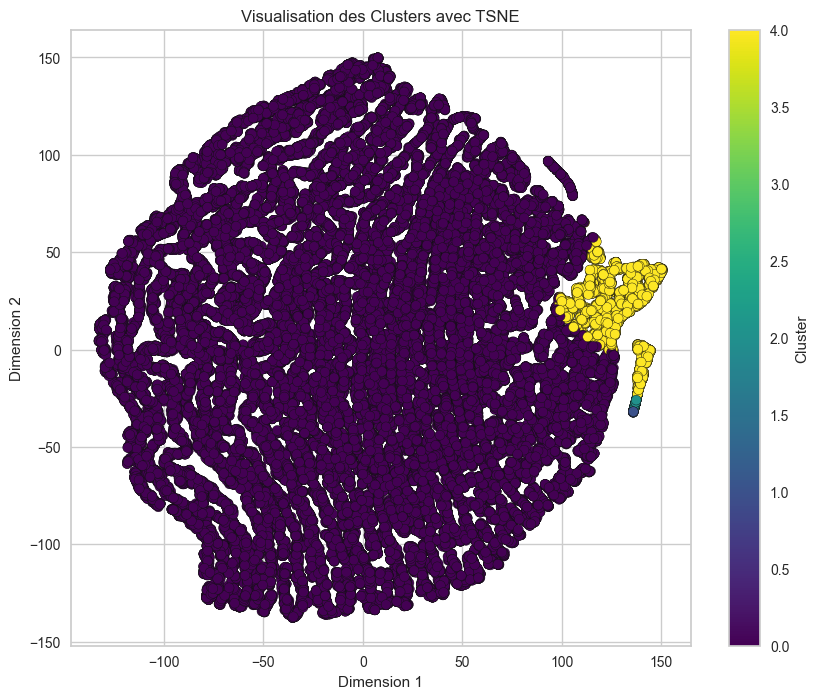

In [90]:
# Mesure du temps d'exécution
debut = time.time()

# Initialisation et entraînement de KMeans
k_kmeans_rfm_sat2 = KMeans(
    n_clusters=kmean_nb_k_rfm_sat2,
    init="k-means++",
    n_init="auto",
    algorithm="lloyd",
    max_iter=300,
    tol=1e-4,
    random_state=77
)
k_kmeans_rfm_sat2.fit(rfm_sat)

# Extraction des étiquettes de clusters
labels_kmeans_rfm_sat2 = k_kmeans_rfm_sat2.labels_

# Calcul du temps d'exécution
fin = time.time()
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution:.4f} secondes (hors visualisation)")

# Réduction de dimension avec TSNE pour visualisation
tsne_3 = TSNE(n_components=2, random_state=77)
reduced_data_tsne_rfm_sat2 = tsne_3.fit_transform(rfm_sat)

# Visualisation des clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data_tsne_rfm_sat2[:, 0], reduced_data_tsne_rfm_sat2[:, 1], c=labels_kmeans_rfm_sat2, cmap="viridis", marker="o", edgecolor="k", s=50)
plt.title("Visualisation des Clusters avec TSNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

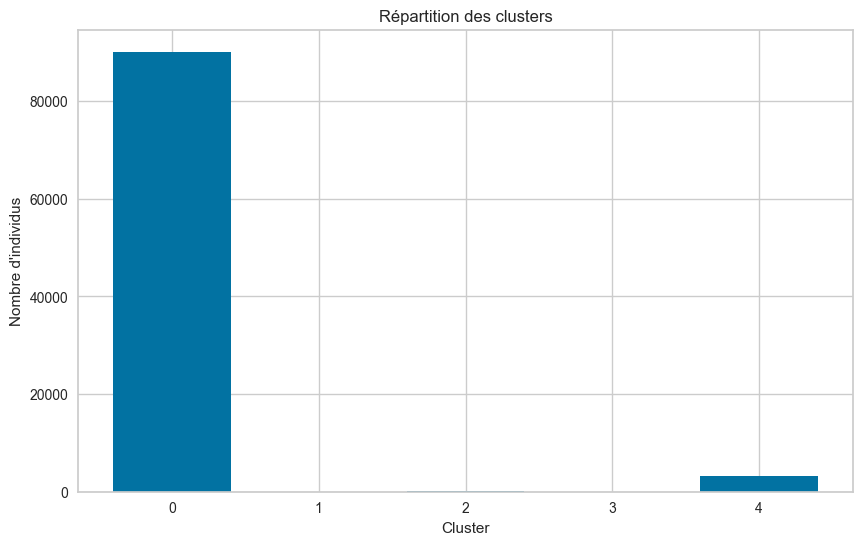

In [91]:
# Visualisation du nombre d'individus dans chaque cluster
unique3, counts3 = np.unique(labels_kmeans_rfm_sat2, return_counts=True)

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(unique3, counts3)
plt.title("Répartition des clusters")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'individus")
plt.xticks(unique3)
plt.show()


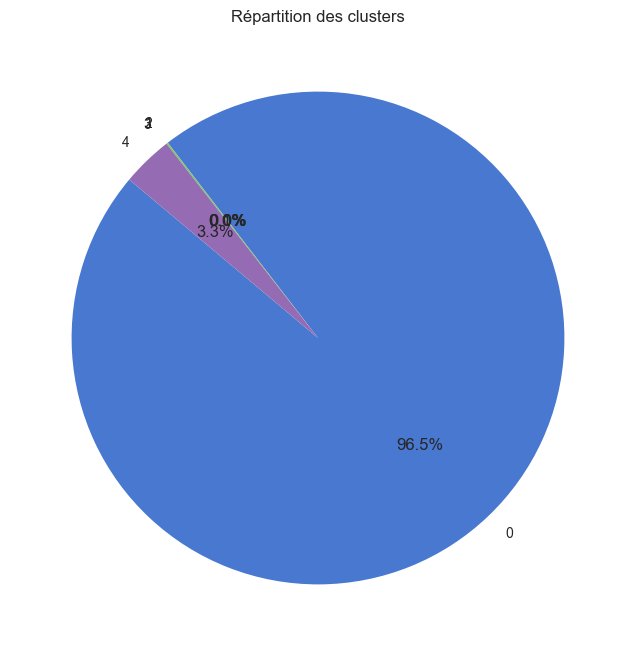

In [92]:
# Création du diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(counts3, labels=unique3, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("muted", 10))
plt.title("Répartition des clusters")
plt.show()

In [93]:
# Aperçu des differents score
kmeans_silhouette = silhouette_score(rfm_sat, labels_kmeans_rfm_sat2)
print(f"Score de silhouette : {kmeans_silhouette:0.3f}")
kmeans_calinski = calinski_harabasz_score(rfm_sat, labels_kmeans_rfm_sat2)
print(f"Score de Calinski_Harabasz : {kmeans_calinski:0.3f}")
kmeans_bouldin = davies_bouldin_score(rfm_sat, labels_kmeans_rfm_sat2)
print(f"Score de Davies_Bouldin : {kmeans_bouldin:0.3f}")
# Uniquement pour KMeans
print(f"Score de distortion : {k_kmeans_rfm_sat2.inertia_:0.3f}")

Score de silhouette : 0.774
Score de Calinski_Harabasz : 116722.519
Score de Davies_Bouldin : 0.475
Score de distortion : 8727517178.851


Les résultats montrent une nette amélioration par rapport au premier essai (toujours sous rfm_satisfaction), avec des clusters mieux répartis et des scores cohérents.    
Toutefois comparé à la méthode RFM , le cumul rfm + score ne donne pas de meilleurs clusters bien définis.

Je recommanderai une gestion via le NPS (Net Promoter Score) pour la gestion de la satisfaction client.    
Ceux-ci seront dissocié en trois catégories, Les détracteurs, les passifs et les promoters.    
Voici comment cette note est calculé : Note NPS = % Promoters - % Détracteurs.

## Récapitulatif des modèles

Modèle  Nombre de clusters  Durée de fit  \
0                    KMeans                   5      1.150501   
1                    DBSCAN                   5      3.867555   
2  Agglomérative Clustering                   4    434.810484   

   Score de silhouette  Score de Davies Bouldin  Score de Calinski Harabasz  
0             0.559391                 0.512153               439003.160450  
1            -0.496182                 2.296859                  587.799173  
2             0.536484                 0.521008               340884.096271

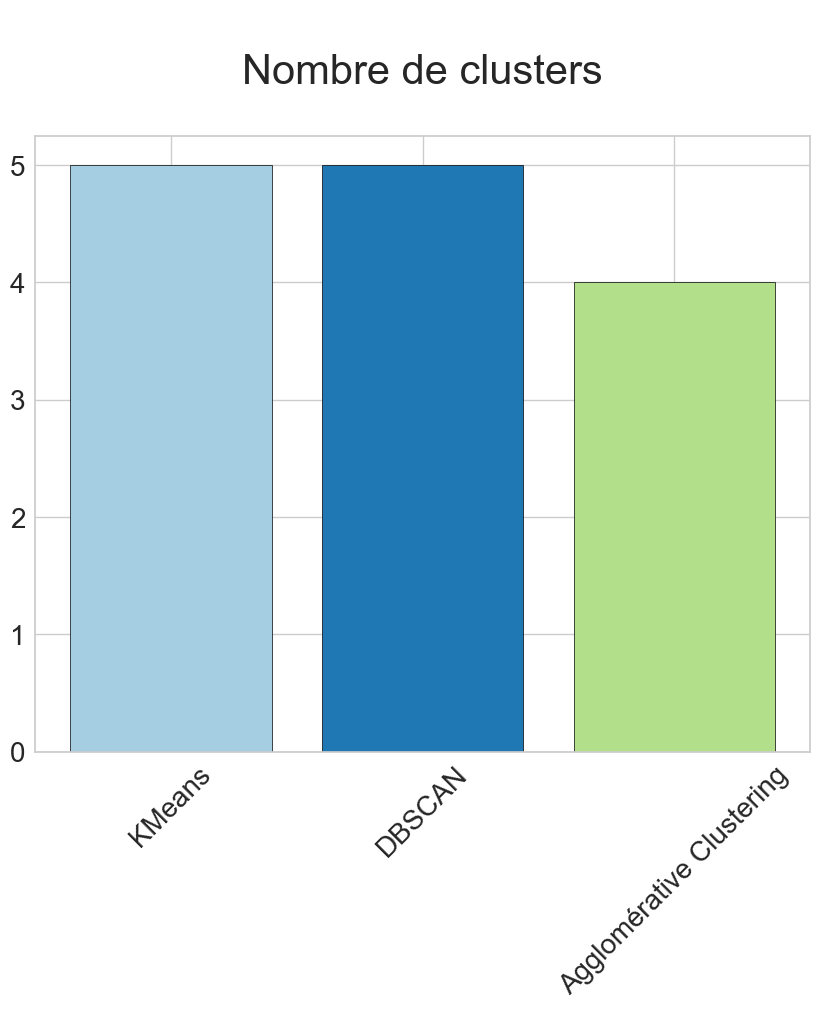

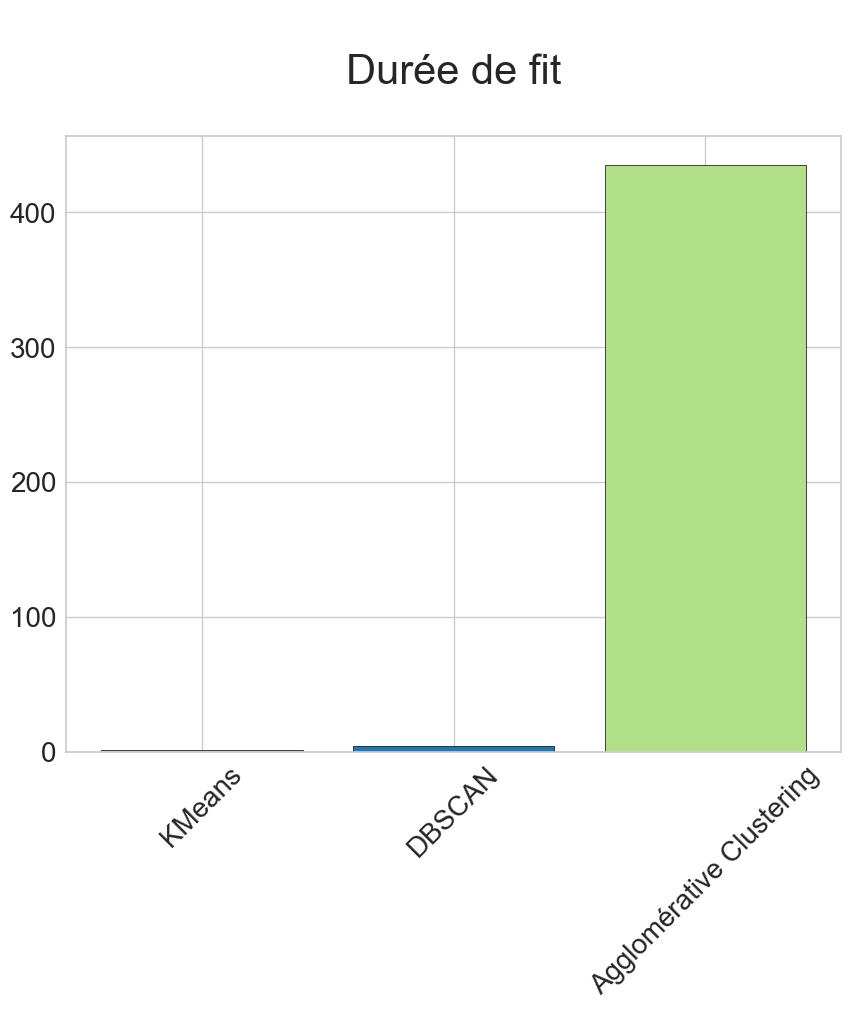

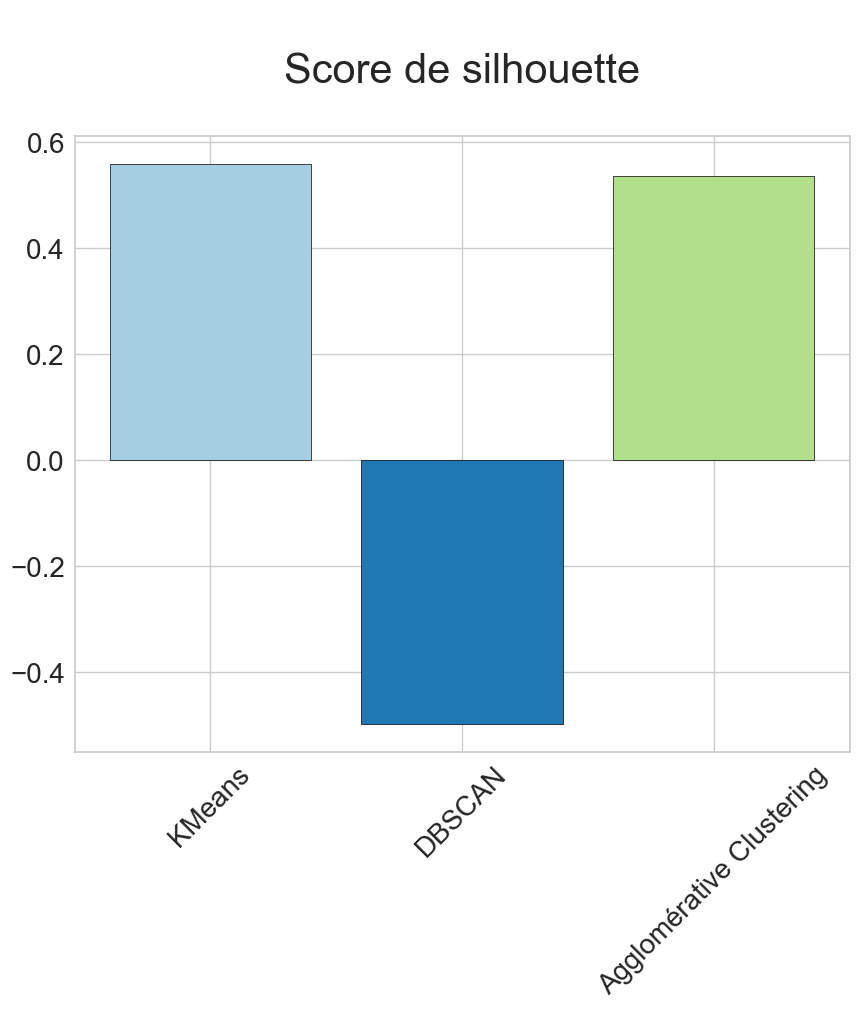

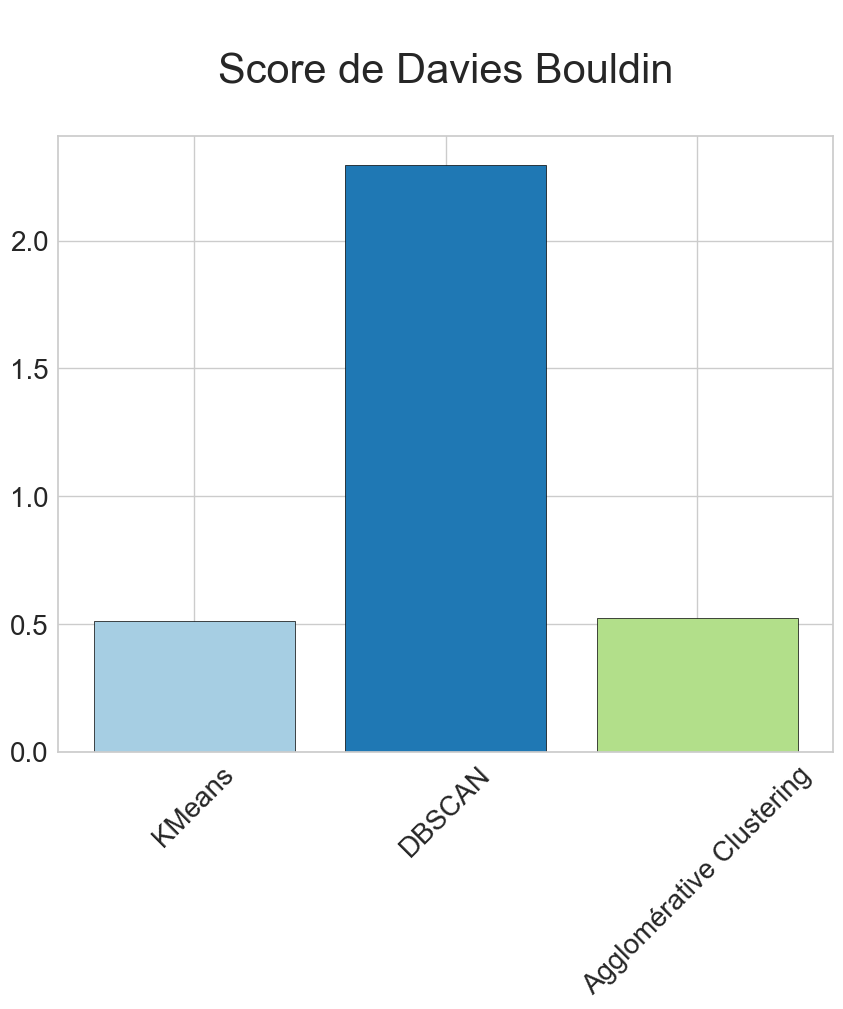

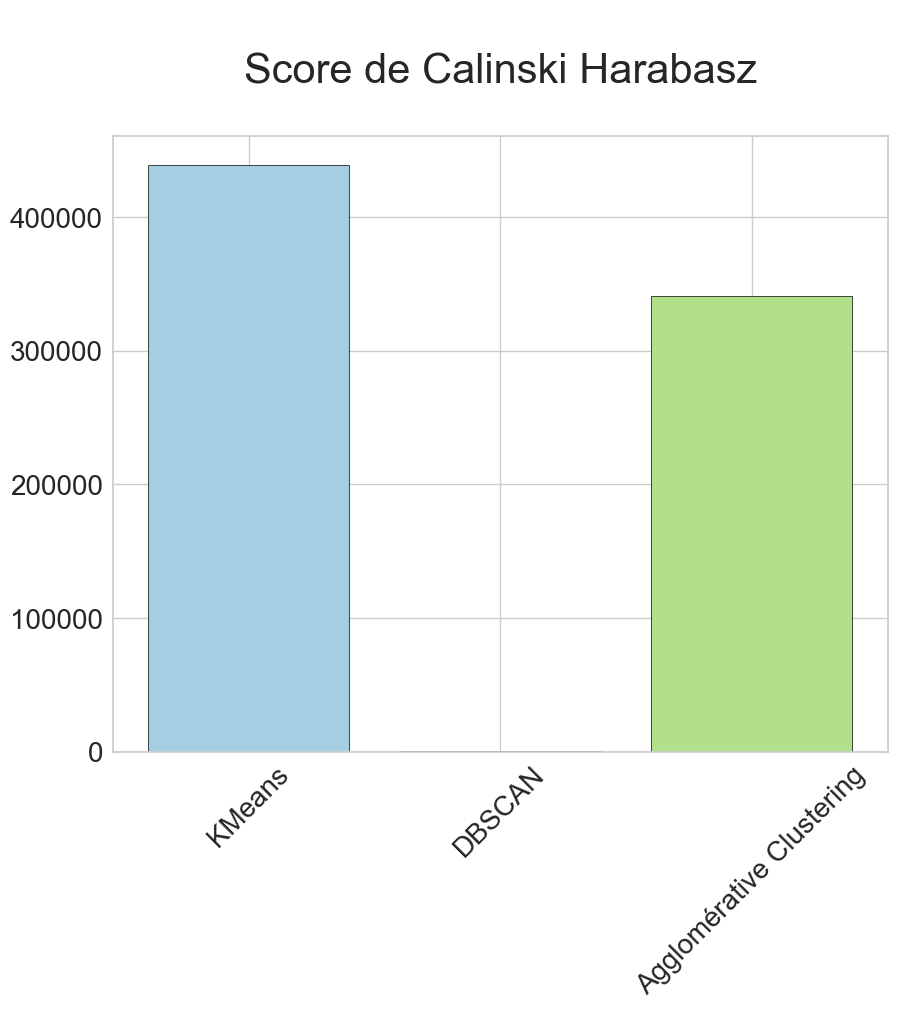

In [ ]:
# Récupération de toutes les métriques et création d'un DF
comparo = {
    "Modèle": [
        "KMeans",
        "DBSCAN",
        "Agglomérative Clustering"
    ],
    "Nombre de clusters": [
        kmean_cluster_nb,
        len(np.unique(labels_dbscan)),
        opti_clusters
    ],
    "Durée de fit": [
        temps_execution_km,
        temps_execution_db,
        temps_execution_aggc
    ],
    "Score de silhouette": [
        kmeans_silhouette,
        dbscan_silhouette,
        aggc_silhouette
    ],
    "Score de Davies Bouldin": [
        kmeans_bouldin,
        dbscan_bouldin,
        aggc_bouldin
    ],
    "Score de Calinski Harabasz": [
        kmeans_calinski,
        dbscan_calinski,
        aggc_calinski
    ]
}
comparo_df = pd.DataFrame(data=comparo)

# Affichage du dataframe
display(comparo_df)

# Comparaison des différentes métriques avec les graphiques en barplots
for i in ["Nombre de clusters", "Durée de fit", "Score de silhouette", "Score de Davies Bouldin", "Score de Calinski Harabasz"]:
    plt.figure(figsize=(10, 8))
    plt.bar(
        comparo_df["Modèle"],
        comparo_df[i],
        color=sns.color_palette("Paired"),
        edgecolor="black",
        linewidth=0.5,
        width=0.8,
    )
    plt.title(f"\n{i}\n", fontsize=30)
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
    plt.show()

# Observations :

<u>Nombre de clusters :</u>
- KMeans et DBSCAN identifient respectivement 5 et 4 clusters.
- Agglomerative Clustering en identifie 4.

<u>Durée de fit :</u>
- KMeans et DBSCAN ont un temps de traitement très court.
- Agglomerative Clustering est beaucoup plus lent a traiter les données, 3896.3849 secondes (64 minutes) pour les recherches de paramètre optimaux et 455.4810 secondes pour l'éxécution du modèle.

<u>Score de silhouette :</u>
- KMeans et Agglomerative Clustering obtiennent un score positif d’environ 0.5, ce qui indique une bonne séparation des clusters.
- DBSCAN affiche un score négatif, suggérant une mauvaise cohésion ou séparation des clusters.

<u>Score de Davies-Bouldin :</u>
- Plus le score est faible, meilleure est la qualité du clustering. Agglomerative Clustering et KMeans montrent une bonne performance avec des clusters de qualité.
- DBSCAN semble inadapté à ces données, car son score de Davies-Bouldin est très élevé.

<u>Score de Calinski-Harabasz :</u>
- KMeans atteint un score très élevé, ce qui suggère une excellente séparation des clusters.
- Agglomerative Clustering est performant mais reste inférieur à KMeans.


**Conclusion** :

- KMeans est globalement la méthode la plus performante. Elle combine un temps de fit rapide, un bon score de silhouette, et d’excellentes performances en termes de Calinski-Harabasz.
- DBSCAN semble inadapté pour ce jeu de données à cause de son score de silhouette négatif et sa difficulté a segmenter les clusters
- Agglomerative Clustering offre une qualité correcte pour certains critères, mais son temps de calcul et son score Davies-Bouldin élevé en font une option moins optimale.

KMeans (RFM) sera donc retenu pour la dernière partie, la Simulation.